In [26]:
import os
import matplotlib.pyplot as plt
import torch
import numpy as np

from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
from torch.distributions import constraints

from pyro.infer.mcmc import NUTS
from pyro.infer.mcmc import MCMC

import arviz as az
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

assert pyro.__version__.startswith('1.8.6')
torch.set_default_dtype(torch.float32)
torch.set_default_device('cpu')
pyro.set_rng_seed(42)
torch.manual_seed(42)

## Problem B1.1

First we define a function used visualize the GPs and the data.

In [27]:
# Function taken from https://pyro.ai/examples/gp.html with some modifications
def plot(
    X_train=None,
    y_train=None,
    X_test=None,
    y_test=None,
    plot_predictions=False,
    posterior_test=None,
    n_prior_samples=0,
    model=None,
    kernel=None,
    n_test=500,
    ax=None
):

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    if X_train is not None and y_train is not None:
        ax.plot(X_train.numpy(), y_train.numpy(), "kx", label="train points")
        plt.legend()
    if X_test is not None and y_test is not None:
        ax.plot(X_test.numpy(), y_test.numpy(), "ko", label="test points")
        plt.legend()
    if plot_predictions:
        Xtest = torch.linspace(-0.1, 1.1, n_test)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        ax.plot(Xtest.numpy(), mean.numpy(), "r", lw=2)  # plot the mean
        ax.fill_between(
            Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
            (mean - 1.95 * sd).numpy(),
            (mean + 1.95 * sd).numpy(),
            color="C0",
            alpha=0.3,
        )
    if posterior_test is not None:
        # compute predictive mean and variance
        pass
        # with torch.no_grad():
        #     if type(model) == gp.models.VariationalSparseGP:
        #         mean, cov = model(X_test, full_cov=True)
        #     else:
        #         mean, cov = model(X_test, full_cov=True, noiseless=False)
        # sd = cov.diag().sqrt()  # standard deviation at each input point x
        # ax.plot(X_test.numpy(), mean.numpy(), "o", label='Predictions')  # plot the mean
        # plt.legend()
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(0.0, 1.0, n_test)  # test inputs
        noise = (
            model.noise
            if type(model) != gp.models.VariationalSparseGP
            else model.likelihood.variance
        )
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(
            torch.zeros(n_test), covariance_matrix=cov
        ).sample(sample_shape=(n_prior_samples,))
        ax.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)
    
    ax.set_xlim(-0.2, 1.2)
    
# function to plot the loss curve
def plot_loss(loss):
    plt.plot(loss)
    plt.xlabel("Iterations")
    _ = plt.ylabel("Loss")  # supress output text

Next we generate a dataset and plot it to get an intuition of what we are working with

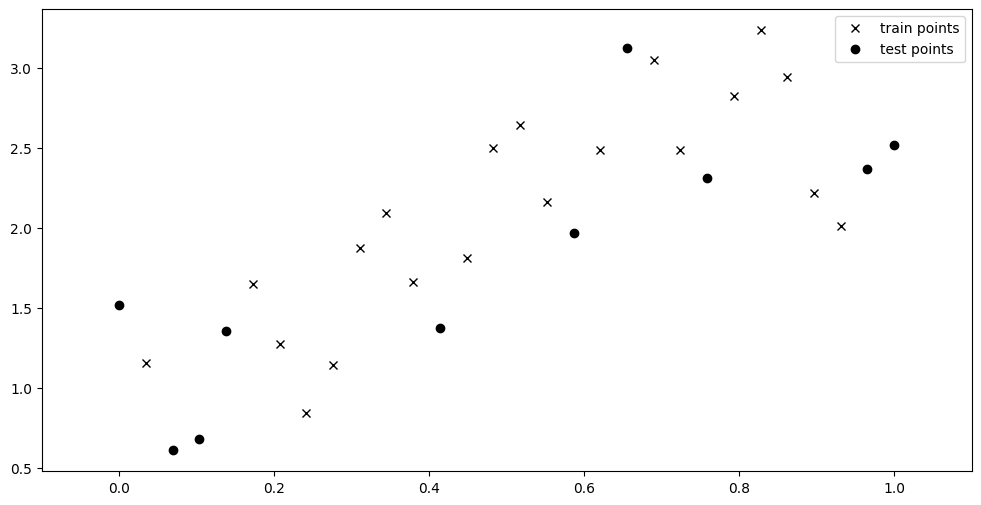

In [28]:
# generate data and plot it
N = 30
X = []
for i in range(1, 31):
    xi = (i - 1)/(30 - 1)
    X.append(xi)

X = torch.tensor(X)
noise = dist.Normal(0.0, 0.01).sample(sample_shape=(N,))
y = -(torch.sin(6 * torch.pi * X))**2 + 6 * X**2 - 5 * X**4 + 3/2 + noise

# split into train and test
indices = torch.randperm(len(X))[:20]
first = torch.arange(0, 30, 1)
diff=first[(first.view(1, -1) != indices.view(-1, 1)).all(dim=0)]

X_train = X[indices]
y_train = y[indices]

X_test = X[diff]
y_test = y[diff]



plot(X_train, y_train, X_test, y_test)  # let's plot the observed data
_ = plt.xlim((-0.1, 1.1))

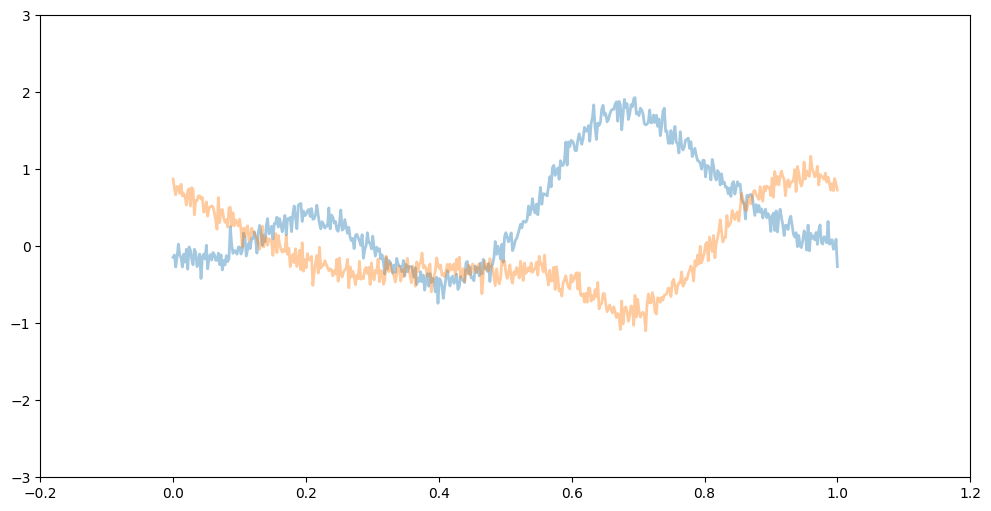

In [29]:
# define kernel with some values and visualize it
pyro.clear_param_store()
kernel = gp.kernels.Periodic(
    input_dim=1, variance=torch.tensor(1.0),
    lengthscale=torch.tensor(1.0),
    period=torch.tensor(1.0) 
)
gpr = gp.models.GPRegression(X_train, y_train, kernel, noise=torch.tensor(0.01))

# plot to see
plot(model=gpr, kernel=kernel, n_prior_samples=2)
_ = plt.ylim((-3, 3))

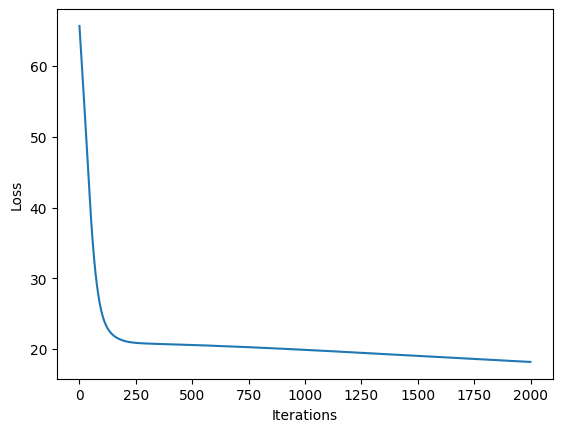

In [30]:
# now lets set some priors
pyro.clear_param_store()

# define model
kernel = gp.kernels.Periodic(
    input_dim=1
)
gpr = gp.models.GPRegression(X_train, y_train, kernel, noise=torch.tensor(0.01))

# set prior mean and variance for each param
mu = 0.
var = 0.5

# set priors on the kernel
gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(mu, var))
gpr.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(mu, var))
gpr.kernel.period = pyro.nn.PyroSample(dist.LogNormal(mu, var))

# create joint prior distribution
mean = torch.tensor([mu, mu, mu])
covar = torch.diag(torch.tensor([var, var, var]))

prior = dist.MultivariateNormal(loc=mean, covariance_matrix=covar)

# LogNormal - obtained by transforming the multivariate normal Y ~ exp(X)
prior = dist.TransformedDistribution(
    dist.MultivariateNormal(loc=mean, covariance_matrix=covar),
    dist.transforms.ExpTransform()
)

# perform gradient descent to optimize parameters
optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
num_steps = 2000
for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plot_loss(losses)

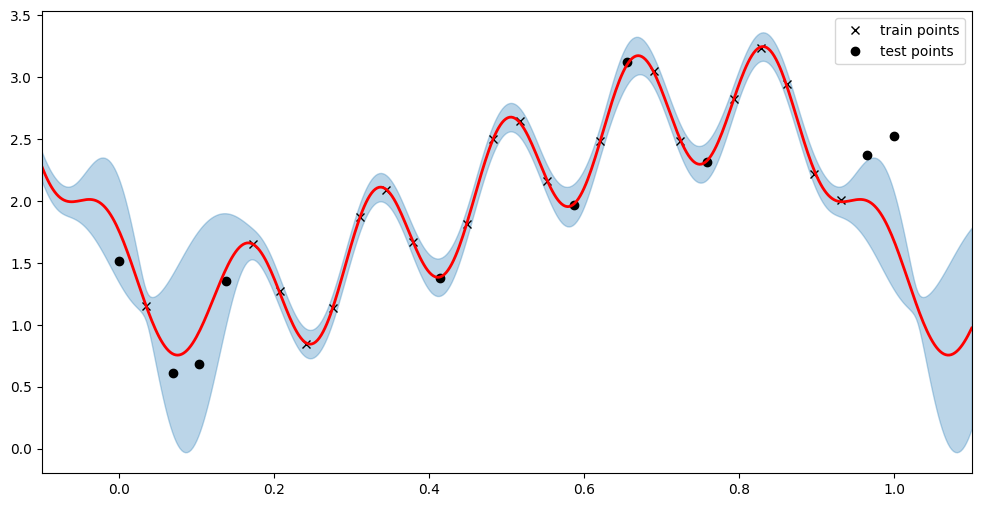

In [31]:
plot(model=gpr, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, plot_predictions=True, posterior_test=X_test)
_ = plt.xlim(-0.1, 1.1)

In [32]:
gpr.set_mode("guide")
print("variance = {}".format(gpr.kernel.variance))
print("lengthscale = {}".format(gpr.kernel.lengthscale))
print("period = {}".format(gpr.kernel.period))
print("noise = {}".format(gpr.noise))

variance = 1.989600658416748
lengthscale = 0.46544212102890015
period = 0.9945930242538452
noise = 0.0020257465075701475


In [33]:
# function to compute the log likelihood
def logLikelihood(params, gpr, X, y, prior):
    l = y.shape[0]
    noise_y = gpr.noise
    K = gpr.kernel(X, X)
    sigma_y_I = noise_y * torch.eye(l)
    inverse = torch.linalg.inv((sigma_y_I + K))
    det = torch.linalg.det((sigma_y_I + K))
    sqrt = torch.sqrt(2 * torch.pi)

    evidence_ll = -0.5 * (y.T @ inverse @ y + torch.log(det) + l * torch.log(sqrt))
    # easy to compute the prior using pyro built in functions
    prior_prob = prior.log_prob(params)

    return evidence_ll + prior_prob

In [34]:
# sample using NUTS
n_samples = 250
n_chains = 2
n_warmup = 500

pyro.clear_param_store()
# compute second moment quantity
nuts_kernel = pyro.infer.NUTS(gpr.model, jit_compile=True)
mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=n_samples, warmup_steps=n_warmup,
                       num_chains=n_chains)
mcmc.run()

Warmup [1]:   0%|          | 0/750 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/750 [00:00, ?it/s]

c:\Users\Mads\Documents\PML\venv\Lib\site-packages\arviz\data\io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(



                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel.lengthscale      0.43      0.06      0.43      0.33      0.51    111.03      1.03
       kernel.period      1.12      0.14      1.07      0.95      1.32    102.85      1.02
     kernel.variance      2.45      0.75      2.31      1.23      3.50    108.09      1.01

Number of divergences: 8
None


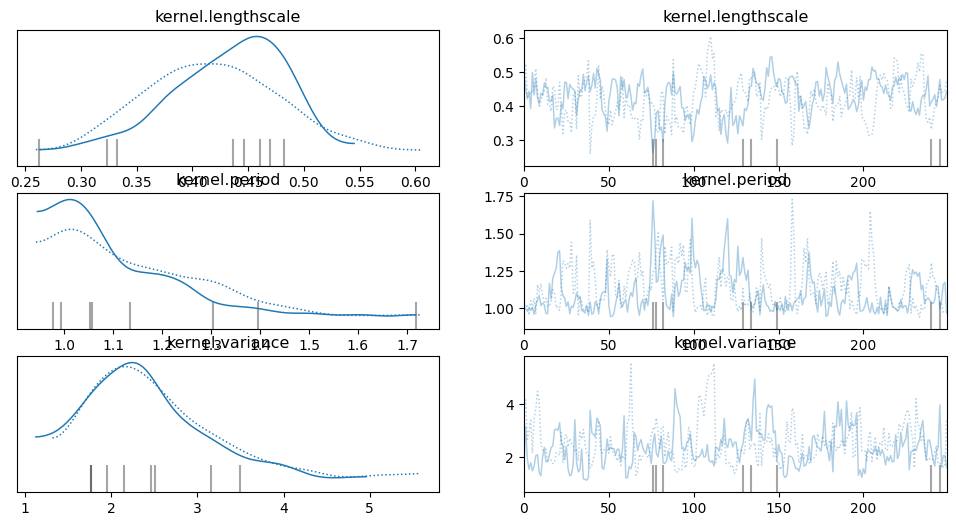

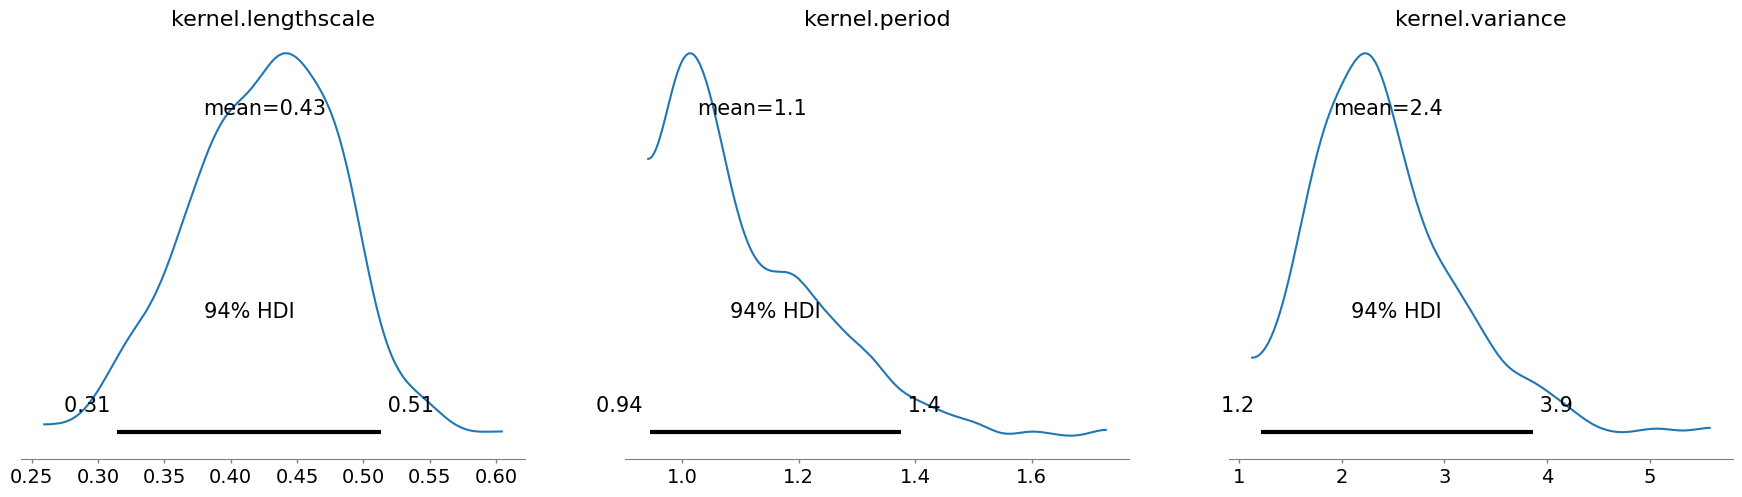

In [35]:
# inspect posterior
samples = mcmc.get_samples()
sample_data = az.from_pyro(mcmc)
sample_summary = az.summary(sample_data)


print(mcmc.summary())
az.plot_trace(sample_data)
plt.show()
az.plot_posterior(sample_data)
plt.show()

In [36]:
means = []
linspace = torch.linspace(0, 1, 101)

vars = 0
for i in range(500):
    gpr.kernel.lengthscale = samples['kernel.lengthscale'][i]
    gpr.kernel.variance = samples['kernel.variance'][i]
    gpr.kernel.period = samples['kernel.period'][i]

    mean, var = gpr(linspace, full_cov=True, noiseless=False)
    means.append(mean.detach().cpu().numpy())
    vars += var


means = np.mean(np.array(means), axis=0)
vars = vars / 500

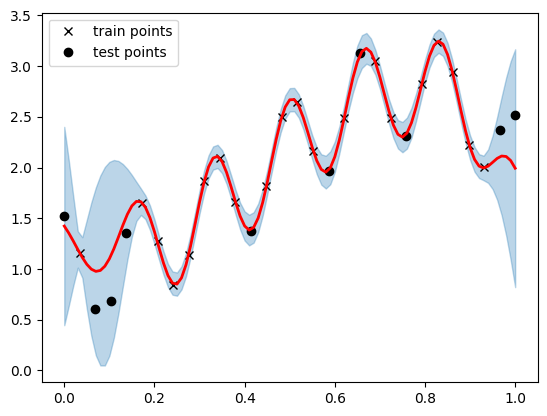

In [37]:
plt.plot(X_train.numpy(), y_train.numpy(), "kx", label="train points")
plt.plot(X_test.numpy(), y_test.numpy(), "ko", label="test points")
plt.legend()

sd = vars.diag().sqrt()  # standard deviation at each input point x
plt.plot(linspace.numpy(), means, "r", lw=2)  # plot the mean
plt.fill_between(
            linspace.numpy(),  # plot the two-sigma uncertainty about the mean
            (means - 1.95 * sd.detach().numpy()),
            (means + 1.95 * sd.detach().numpy()),
            color="C0",
            alpha=0.3,
        )
plt.show()

In [38]:
# lets generate 20 datasets
xtrains = []
xtests = []
ytrains = []
ytests = []
indix = []

l = 30
X = []
for i in range(1, 31):
    xi = (i - 1)/(l - 1)
    X.append(xi)
X = torch.tensor(X)

for k in range(20):
    # set seeds
    torch.manual_seed(k)
    pyro.set_rng_seed(k)
    
    # generate points
    noise = dist.Normal(0.0, 0.01).sample(sample_shape=(N,))
    y = -(torch.sin(6 * torch.pi * X))**2 + 6 * X**2 - 5 * X**4 + 1.5 + noise
    
    # split into train and test
    indices = torch.randperm(len(X))[:20]
    first = torch.arange(0, 30, 1)
    diff=first[(first.view(1, -1) != indices.view(-1, 1)).all(dim=0)]
    
    X_train = X[indices]
    y_train = y[indices]
    
    X_test = X[diff]
    y_test = y[diff]
    
    xtrains.append(X_train)
    ytrains.append(y_train)
    xtests.append(X_test)
    ytests.append(y_test)

variance = 2.449270486831665
lengthscale = 0.2807452082633972
period = 0.3175812065601349
noise = 0.027664098888635635
Log Likelihood:  0.33065786957740784


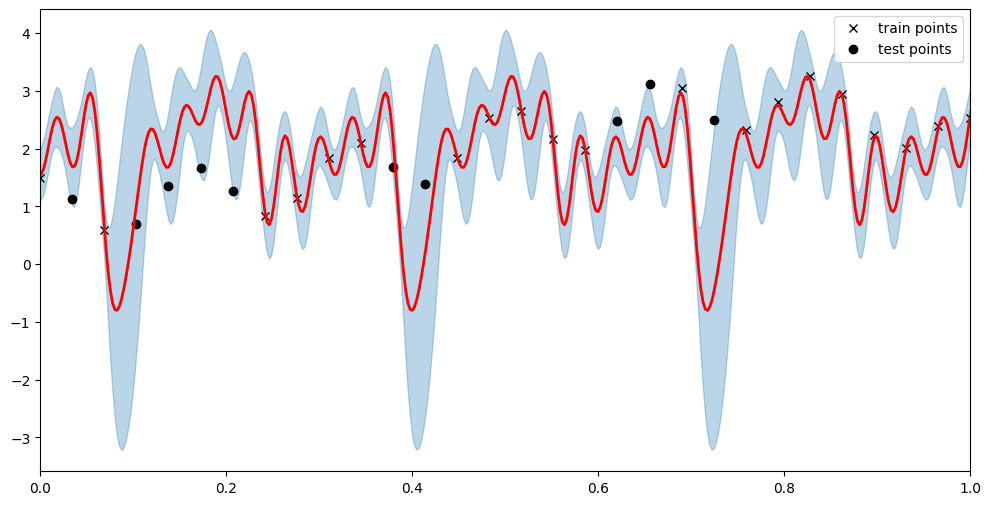

variance = 1.9293429851531982
lengthscale = 0.456245481967926
period = 1.0509803295135498
noise = 0.005669887643307447
Log Likelihood:  2.400613784790039


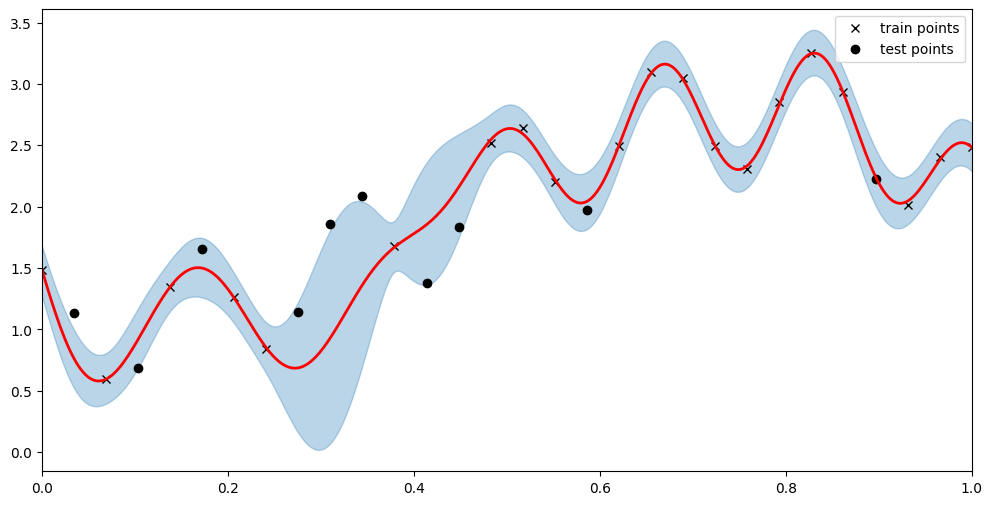

variance = 1.960244059562683
lengthscale = 0.4299547076225281
period = 1.0655937194824219
noise = 0.014765854924917221
Log Likelihood:  1.8797004222869873


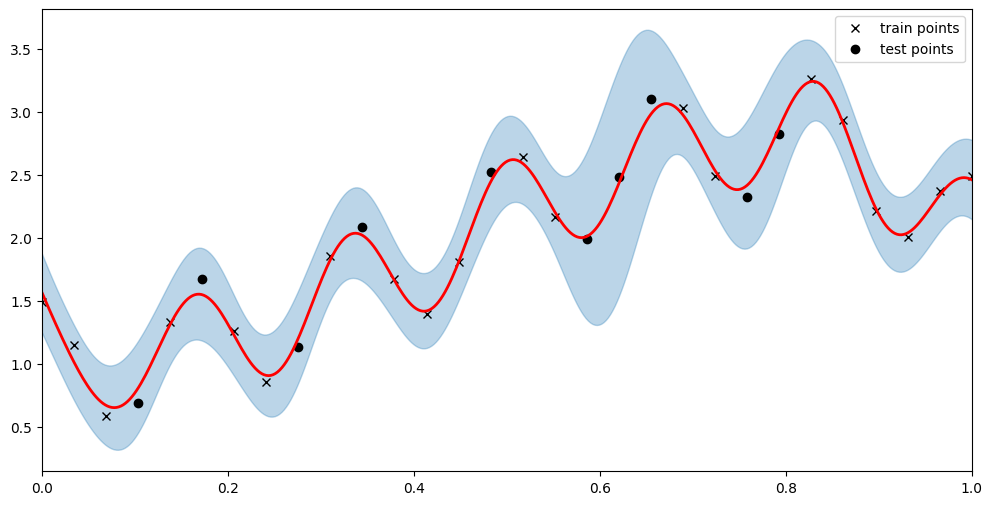

variance = 1.8752721548080444
lengthscale = 0.42952871322631836
period = 1.06996750831604
noise = 0.013207491487264633
Log Likelihood:  1.929762840270996


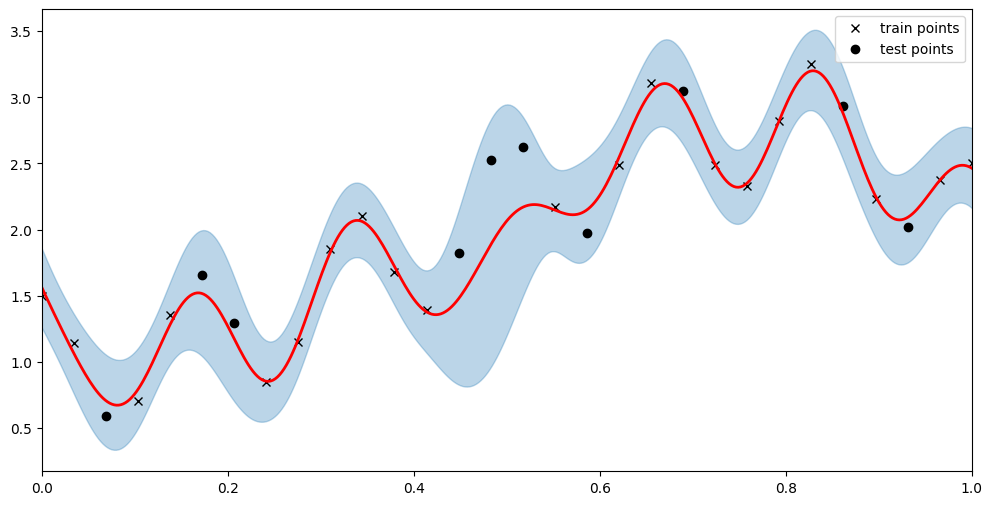

variance = 1.9593849182128906
lengthscale = 0.4169563353061676
period = 1.0880892276763916
noise = 0.00690635247156024
Log Likelihood:  2.361494541168213


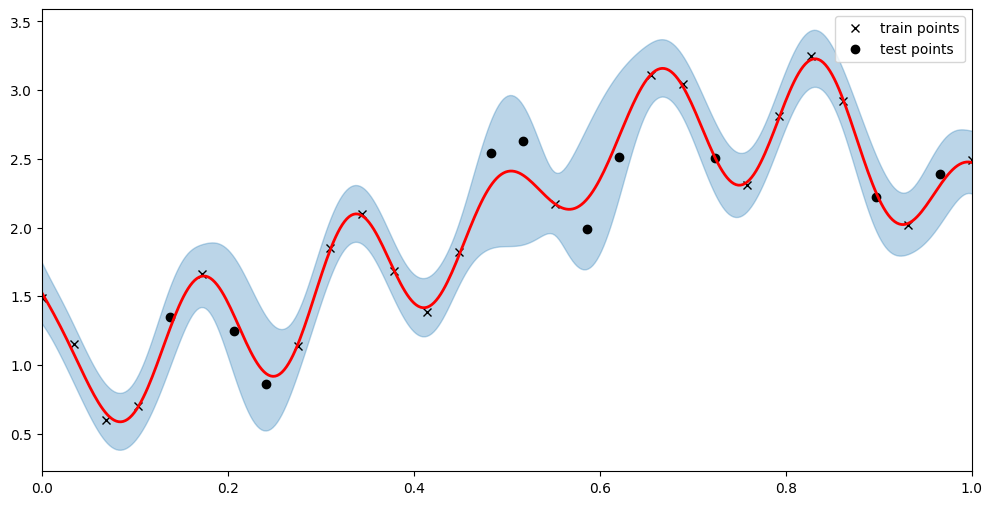

variance = 1.9683306217193604
lengthscale = 0.42725929617881775
period = 1.0743892192840576
noise = 0.011130327358841896
Log Likelihood:  2.2087128162384033


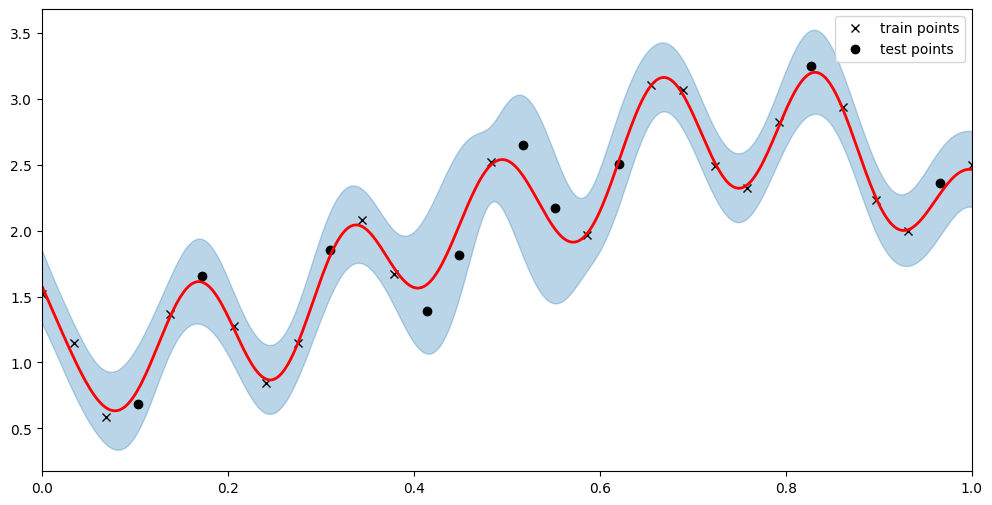

variance = 2.106539487838745
lengthscale = 0.46575576066970825
period = 1.0225012302398682
noise = 6.863021553726867e-05
Log Likelihood:  4.3281097412109375


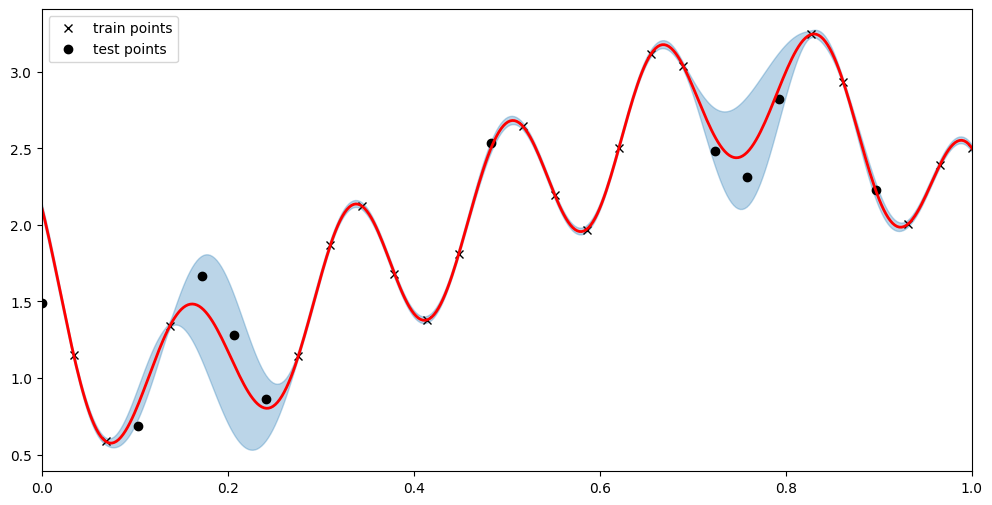

variance = 1.9737414121627808
lengthscale = 0.4306218922138214
period = 1.0741878747940063
noise = 0.012437375262379646
Log Likelihood:  2.5788931846618652


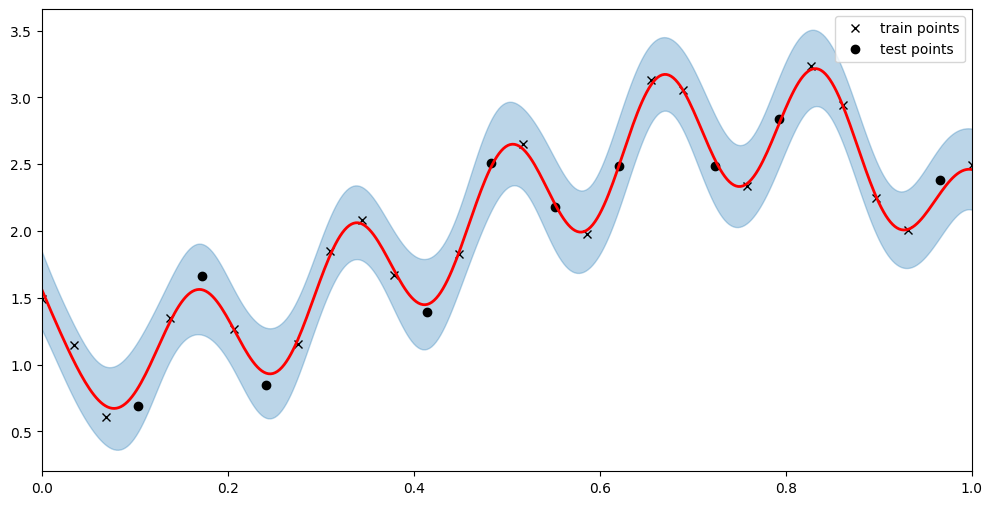

variance = 1.8560459613800049
lengthscale = 0.4270004630088806
period = 1.081842064857483
noise = 0.010177251882851124
Log Likelihood:  2.2582919597625732


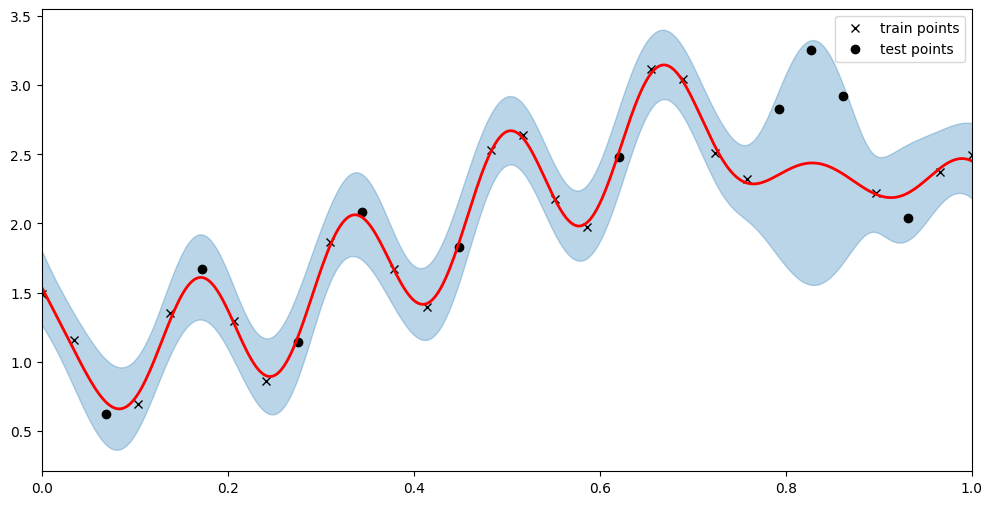

variance = 2.050602912902832
lengthscale = 0.44079744815826416
period = 1.0381407737731934
noise = 0.0035750344395637512
Log Likelihood:  2.5221309661865234


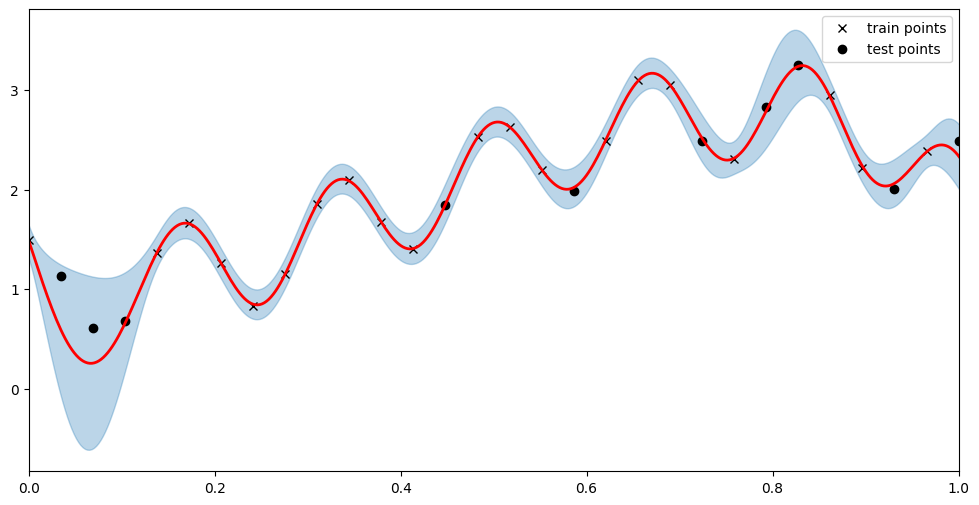

variance = 1.8570570945739746
lengthscale = 0.43168744444847107
period = 1.0753953456878662
noise = 0.010145650245249271
Log Likelihood:  1.791792631149292


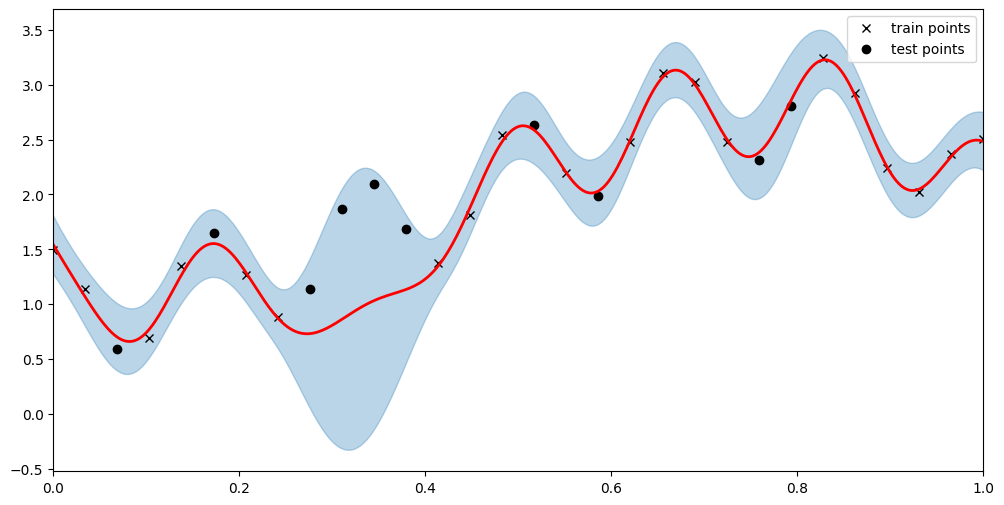

variance = 2.028501033782959
lengthscale = 0.456199049949646
period = 1.0323352813720703
noise = 0.01219556387513876
Log Likelihood:  2.236327648162842


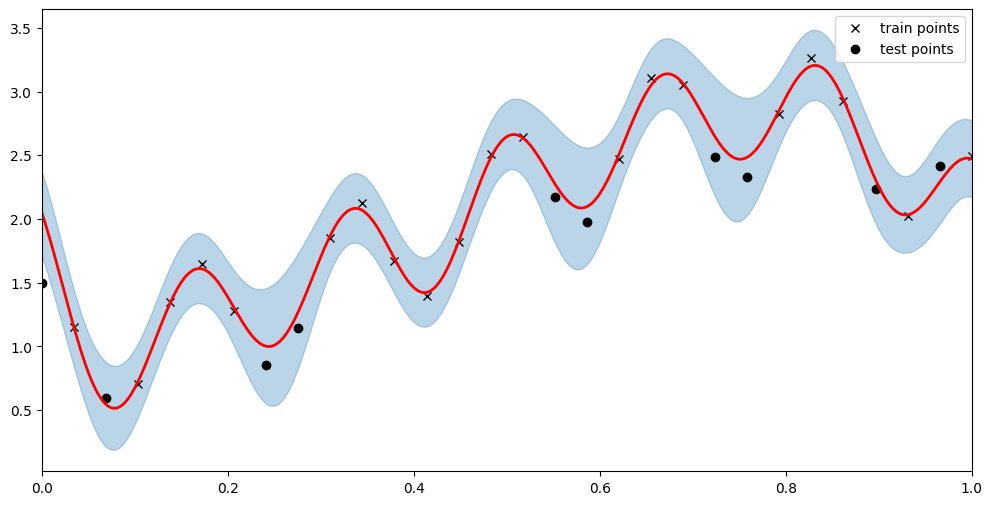

variance = 2.0305399894714355
lengthscale = 0.4542330801486969
period = 1.03187894821167
noise = 0.004172585438936949
Log Likelihood:  2.4002223014831543


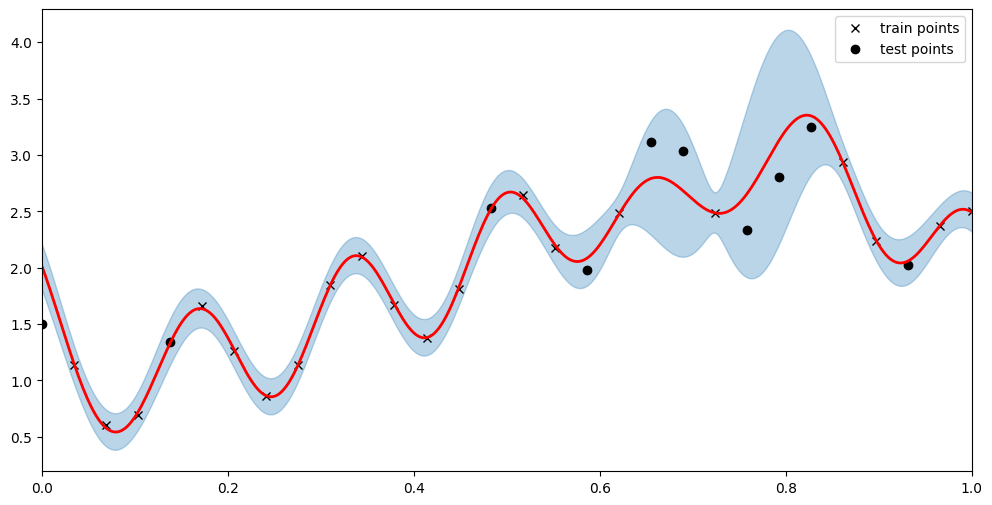

variance = 2.0043392181396484
lengthscale = 0.42670899629592896
period = 1.0697704553604126
noise = 0.008451295085251331
Log Likelihood:  1.7511091232299805


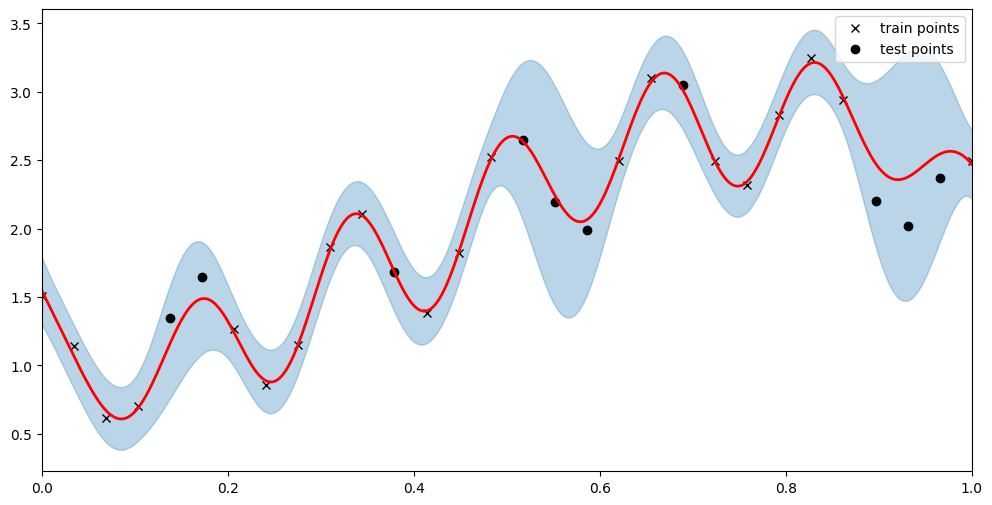

variance = 1.4673818349838257
lengthscale = 0.8916115164756775
period = 0.7383200526237488
noise = 0.3172806203365326
Log Likelihood:  -0.08271308243274689


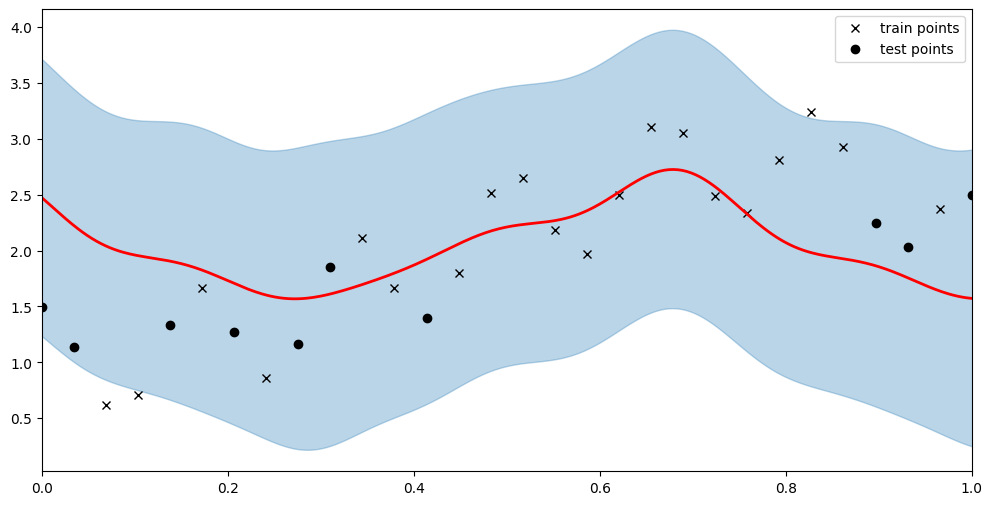

variance = 1.054208755493164
lengthscale = 1.5707974433898926
period = 1.3033894300460815
noise = 0.142127126455307
Log Likelihood:  0.8334935307502747


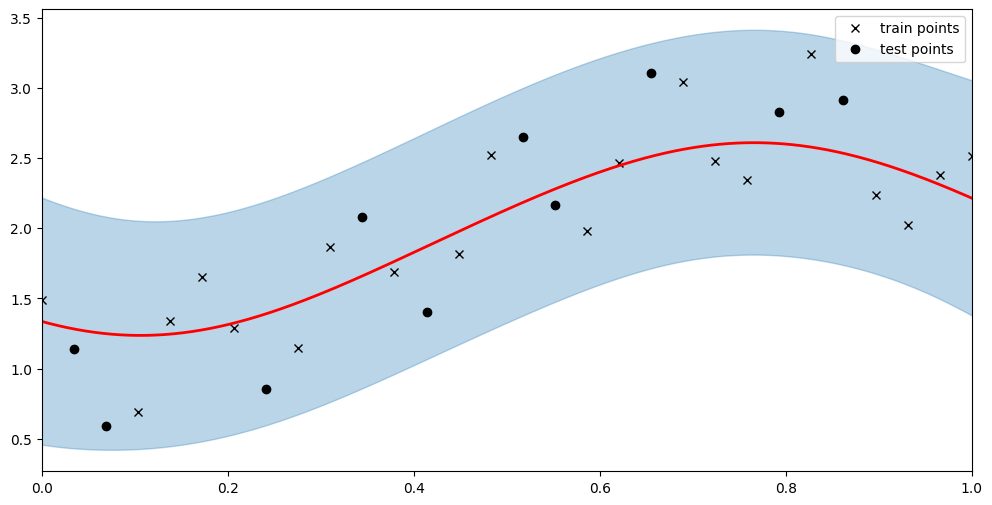

variance = 1.9644315242767334
lengthscale = 0.41699880361557007
period = 1.0873525142669678
noise = 0.005604598671197891
Log Likelihood:  2.7454981803894043


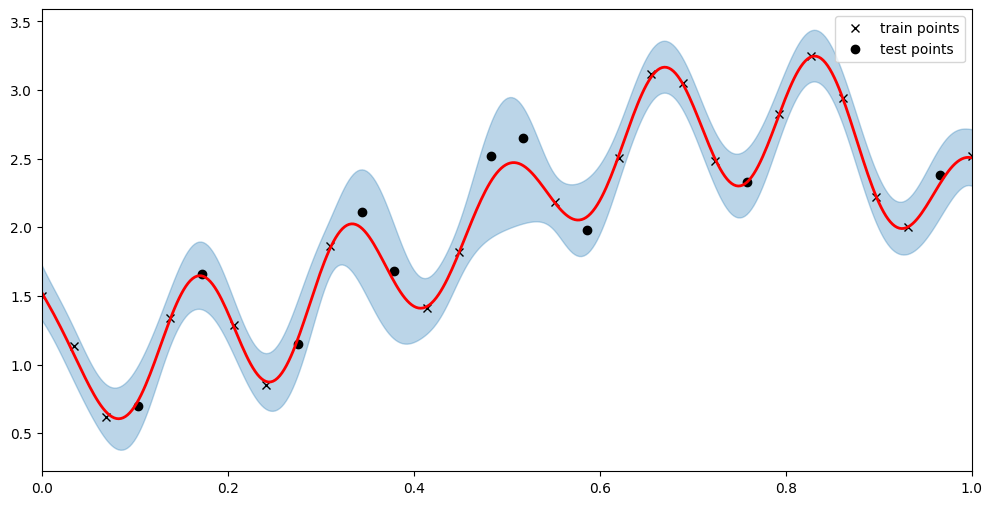

variance = 2.049621343612671
lengthscale = 0.4079223573207855
period = 1.1089409589767456
noise = 0.00024905632017180324
Log Likelihood:  4.273059844970703


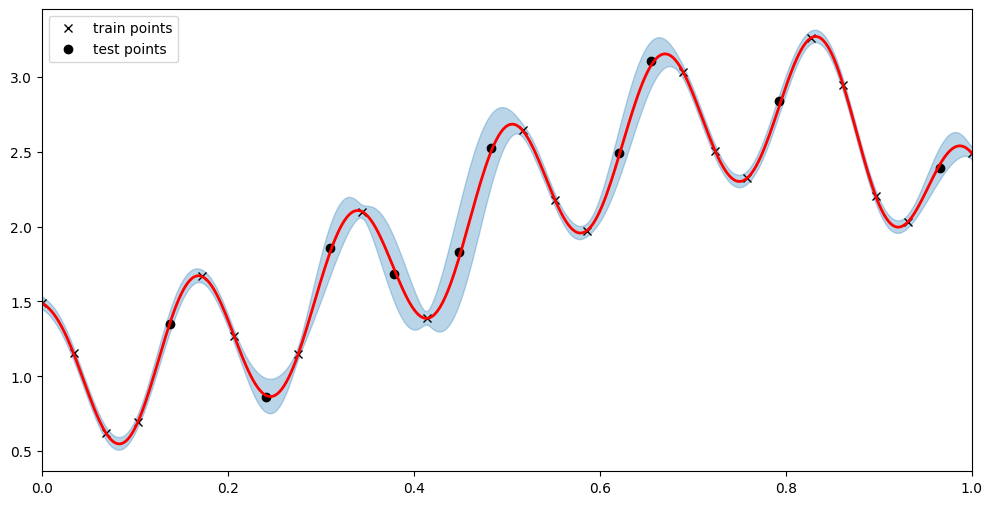

variance = 2.8410656452178955
lengthscale = 0.17637616395950317
period = 0.7070676684379578
noise = 0.037641867995262146
Log Likelihood:  -1.0958043336868286


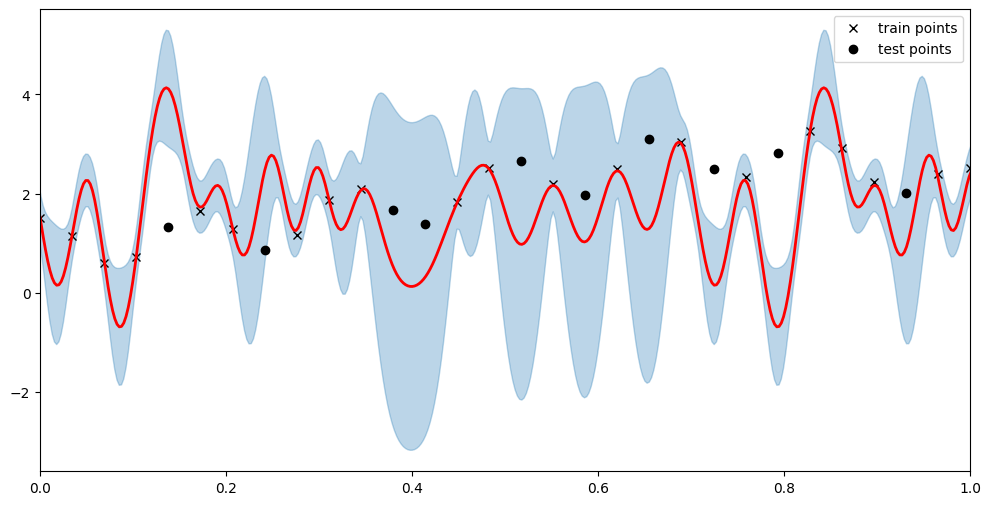

variance = 1.8382799625396729
lengthscale = 0.4429359436035156
period = 1.0659774541854858
noise = 0.012123609893023968
Log Likelihood:  1.7010090351104736


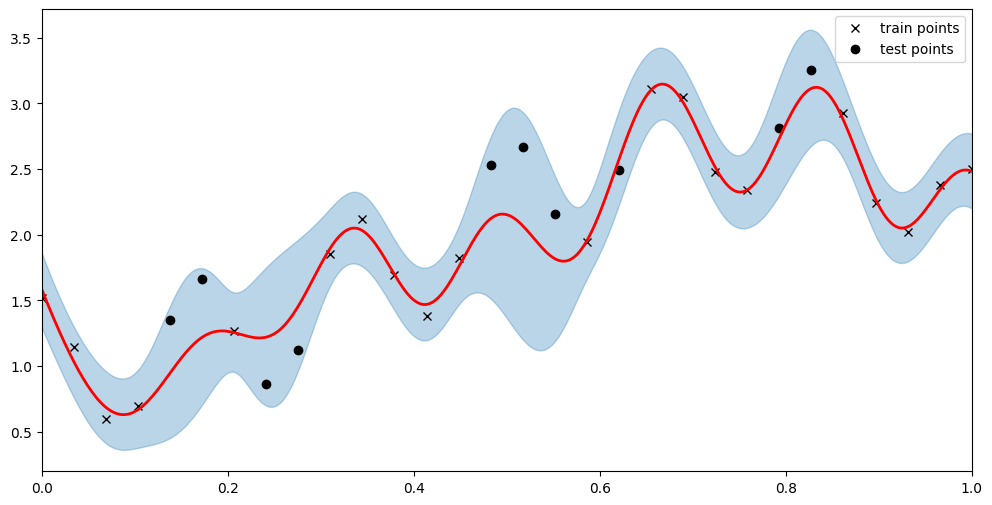

In [39]:
ypreds = []
testlikelihoods = []

# prior mean and var
mu = 0.
var = 0.5

# create joint prior distribution
mean = torch.tensor([mu, mu, mu])
covar = torch.diag(torch.tensor([var, var, var]))

prior = dist.MultivariateNormal(loc=mean, covariance_matrix=covar)

# LogNormal - obtained by transforming the multivariate normal Y ~ exp(X)
prior = dist.TransformedDistribution(
    dist.MultivariateNormal(loc=mean, covariance_matrix=covar),
    dist.transforms.ExpTransform()
)


for k in range(20):
    torch.manual_seed(k)
    pyro.set_rng_seed(k)
    pyro.clear_param_store()

    # define model
    kernel = gp.kernels.Periodic(
        input_dim=1
    )
    gpr = gp.models.GPRegression(xtrains[k], ytrains[k], kernel, noise=torch.tensor(0.01))

    # set priors on the kernel
    gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(mu, var))
    gpr.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(mu, var))
    gpr.kernel.period = pyro.nn.PyroSample(dist.LogNormal(mu, var))
    gpr.set_mode("model")

    # perform gradient descent to optimize parameters
    optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
    loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
    losses = []
    num_steps = 2000
    for i in range(num_steps):
        optimizer.zero_grad()
        loss = loss_fn(gpr.model, gpr.guide)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    
    # print params after training
    gpr.set_mode("guide")
    print("variance = {}".format(gpr.kernel.variance))
    print("lengthscale = {}".format(gpr.kernel.lengthscale))
    print("period = {}".format(gpr.kernel.period))
    print("noise = {}".format(gpr.noise))

    temp = []
    ms, s = gpr(xtests[k], full_cov=True, noiseless=False)
    for j in range(len(ms)):
        test_likelihood = torch.distributions.normal.Normal(ms[j], s[j, j]).log_prob(ms[j])
        temp.append(test_likelihood)
    temp = torch.tensor(temp)
    mean_temp = torch.mean(temp)
    print("Log Likelihood: ", mean_temp.item())
    testlikelihoods.append(mean_temp)

    # generate plot
    plot(model=gpr, X_train=xtrains[k], y_train=ytrains[k], X_test=xtests[k], y_test=ytests[k], posterior_test=xtests[k], plot_predictions=True)
    _ = plt.xlim(0, 1)
    plt.show()

Warmup [1]:   0%|          | 0/750 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/750 [00:00, ?it/s]


                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel.lengthscale      0.41      0.05      0.41      0.33      0.49     65.88      1.03
       kernel.period      1.15      0.13      1.09      1.03      1.35     77.21      1.06
     kernel.variance      2.26      0.68      2.18      1.29      3.21     79.94      1.01

Number of divergences: 0
None


c:\Users\Mads\Documents\PML\venv\Lib\site-packages\arviz\data\io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


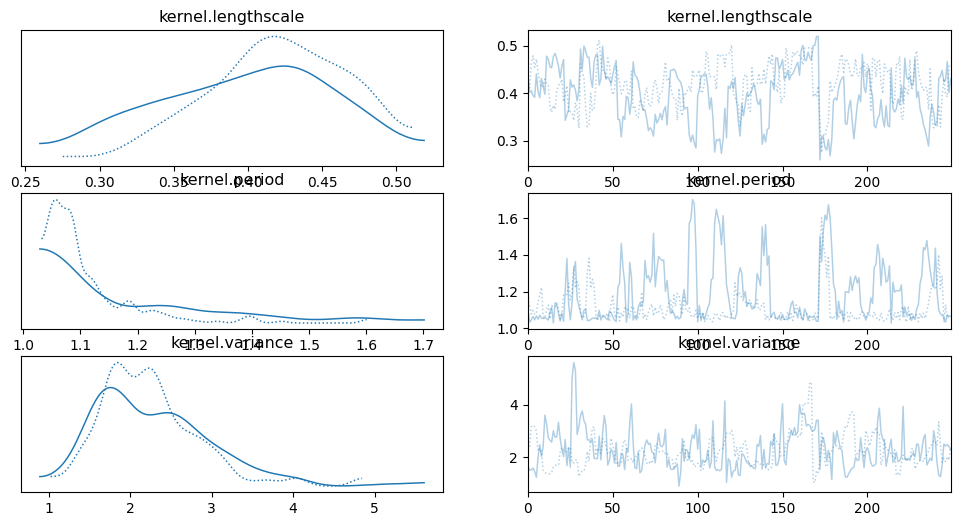

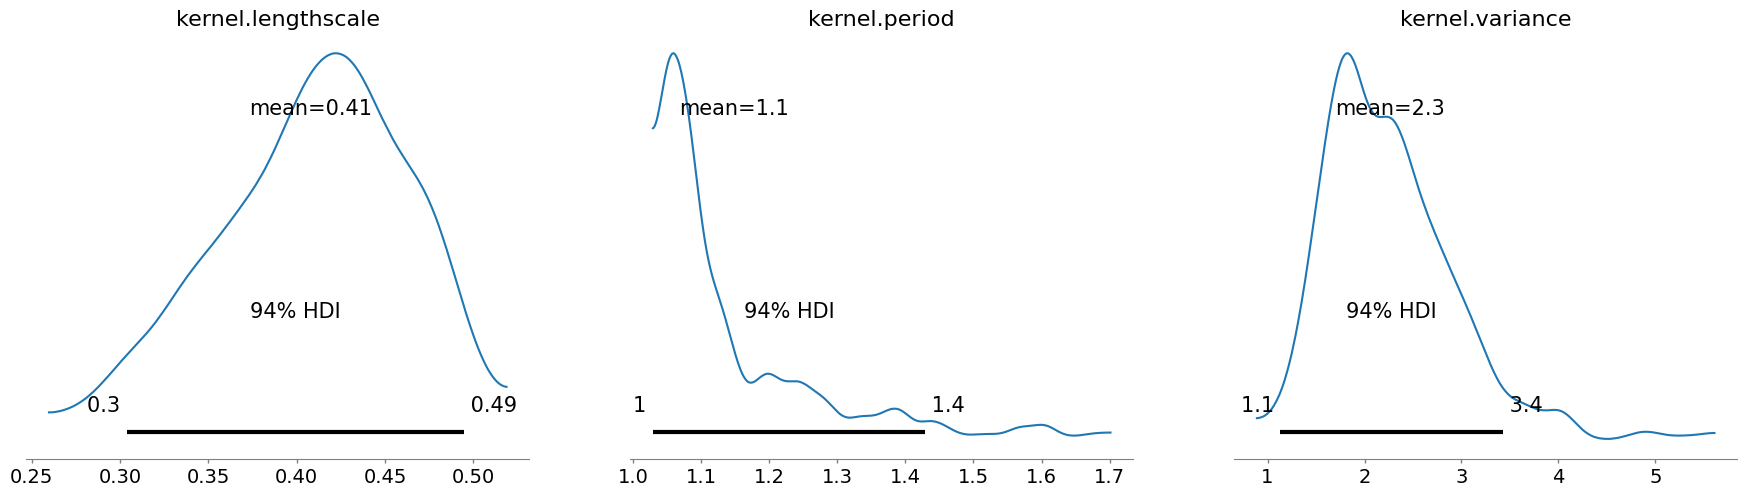

Log Likelihood:  tensor(1.3473)


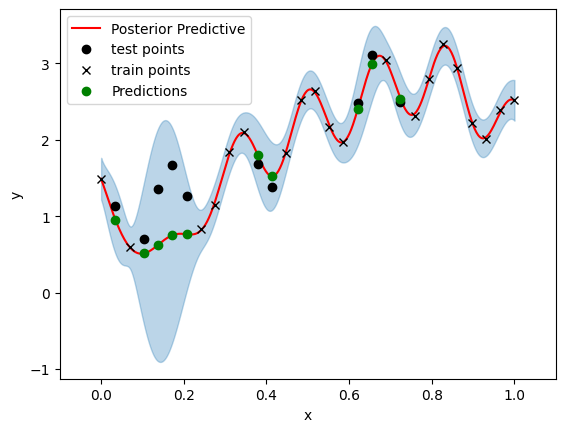

Warmup [1]:   0%|          | 0/750 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/750 [00:00, ?it/s]


                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel.lengthscale      0.43      0.06      0.44      0.34      0.53     41.81      1.05
       kernel.period      1.14      0.14      1.07      1.03      1.36     44.50      1.04
     kernel.variance      2.23      0.63      2.16      1.17      2.98     63.04      1.03

Number of divergences: 1
None


c:\Users\Mads\Documents\PML\venv\Lib\site-packages\arviz\data\io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


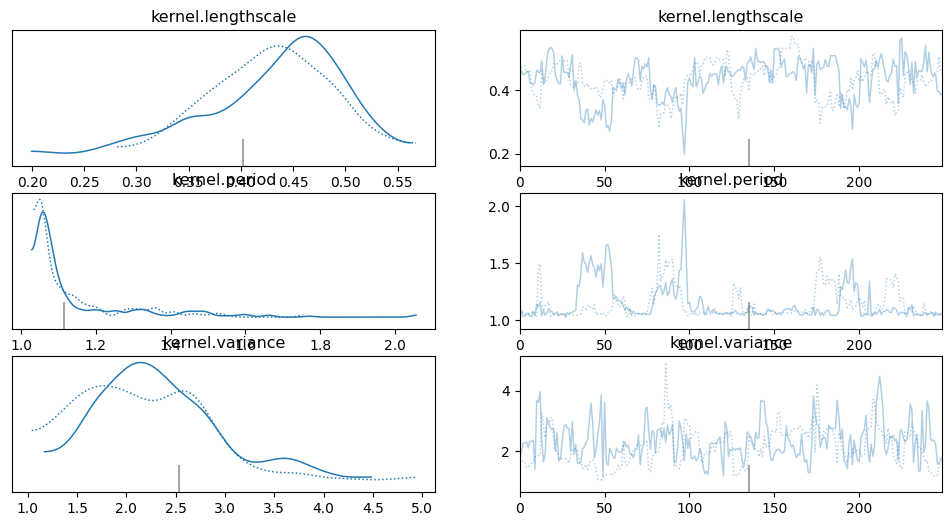

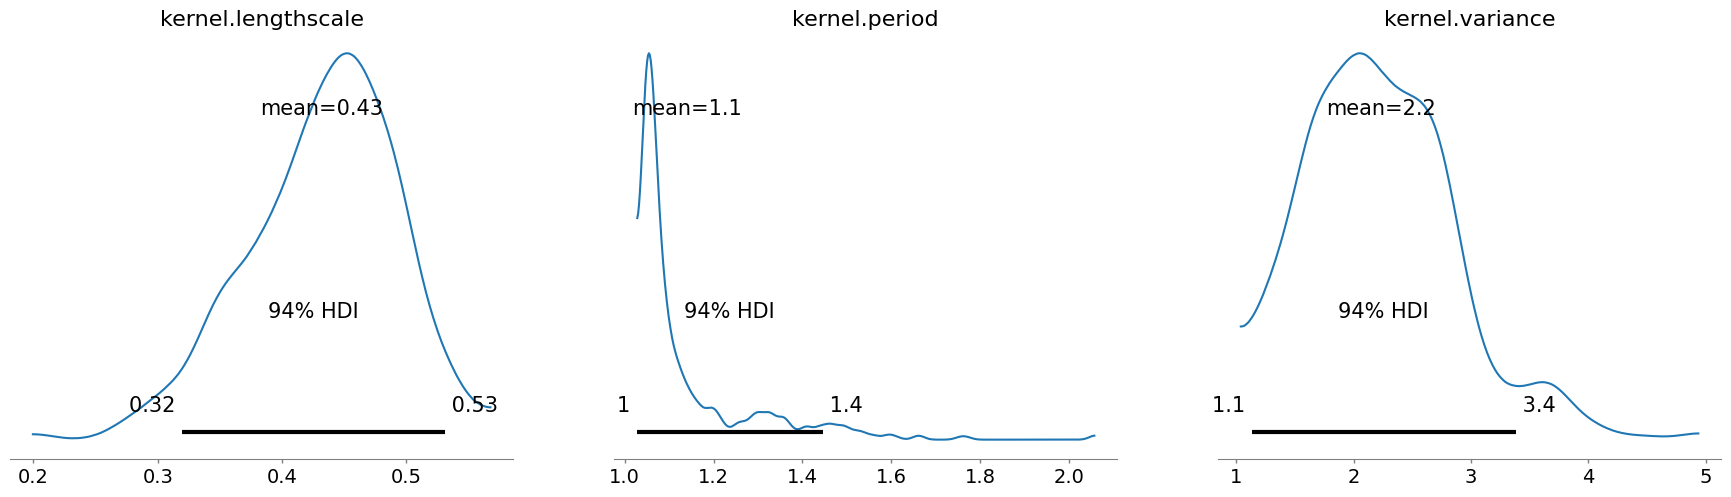

Log Likelihood:  tensor(1.9981)


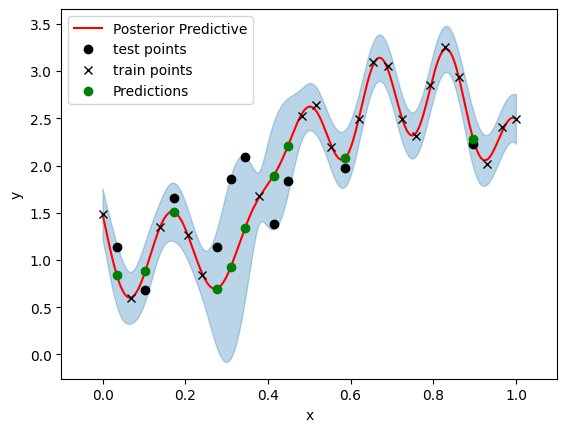

Warmup [1]:   0%|          | 0/750 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/750 [00:00, ?it/s]


                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel.lengthscale      0.38      0.06      0.39      0.29      0.48    107.35      1.00
       kernel.period      1.20      0.18      1.14      1.04      1.45    112.43      1.00
     kernel.variance      2.31      0.72      2.20      1.29      3.41    133.56      1.02

Number of divergences: 0
None


c:\Users\Mads\Documents\PML\venv\Lib\site-packages\arviz\data\io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


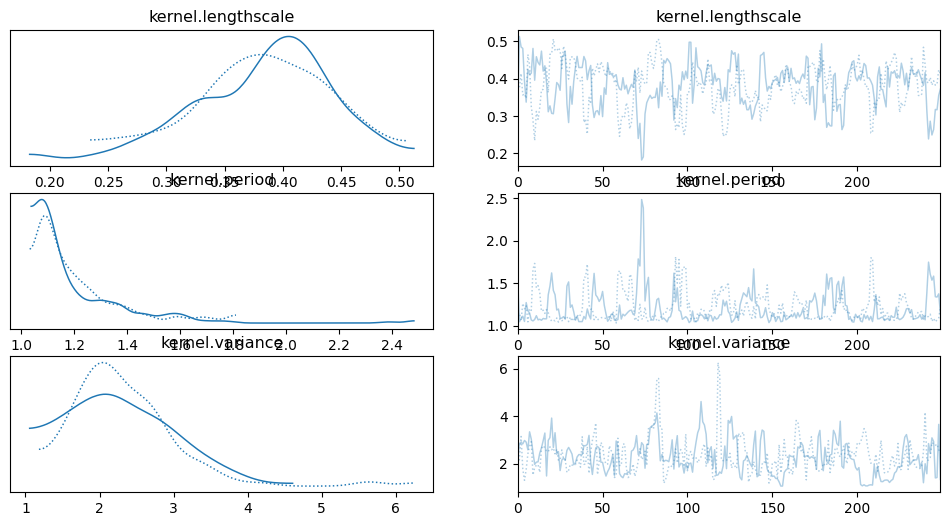

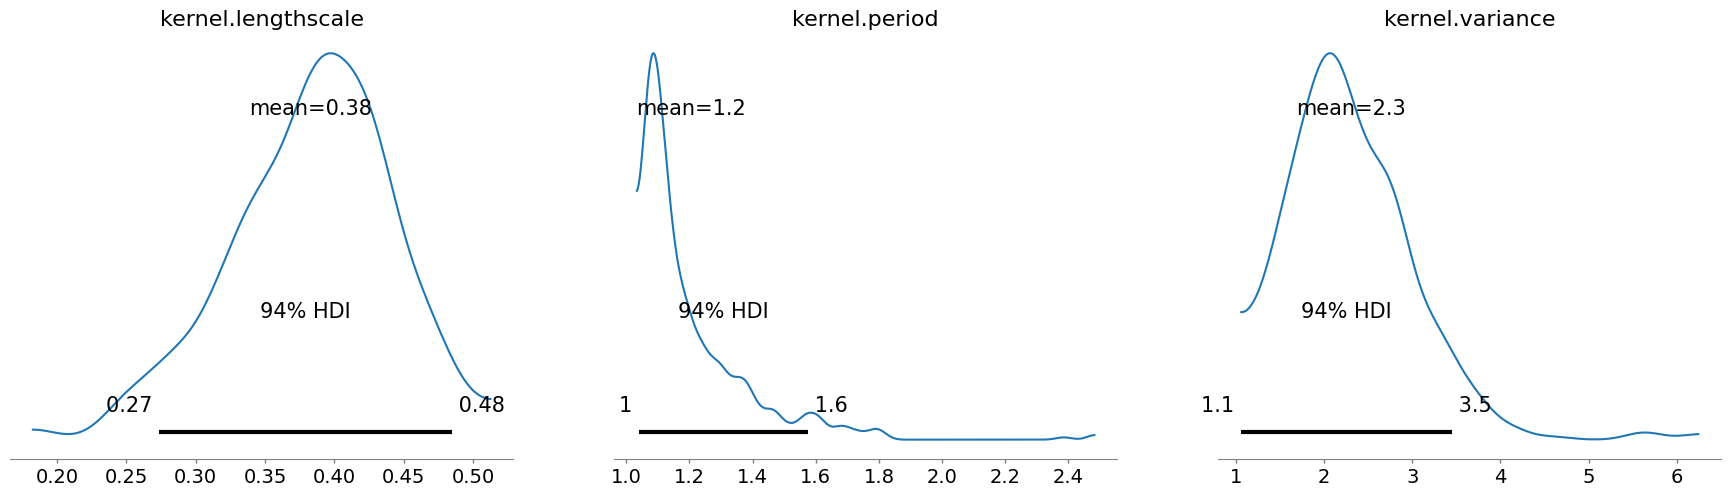

Log Likelihood:  tensor(2.0475)


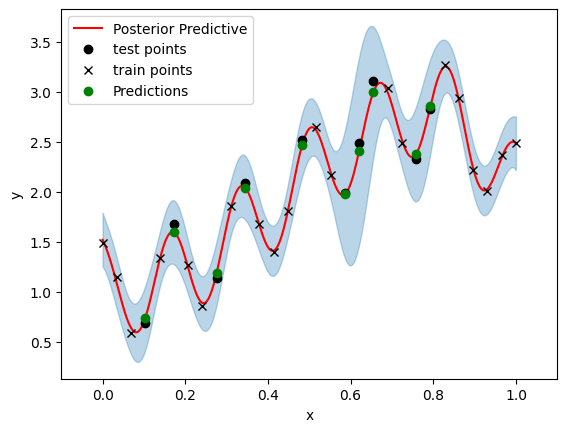

Warmup [1]:   0%|          | 0/750 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/750 [00:00, ?it/s]


                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel.lengthscale      0.38      0.06      0.39      0.31      0.48     69.19      1.02
       kernel.period      1.22      0.20      1.15      1.04      1.45     70.94      1.03
     kernel.variance      2.25      0.65      2.15      1.23      3.18    255.60      1.00

Number of divergences: 0
None


c:\Users\Mads\Documents\PML\venv\Lib\site-packages\arviz\data\io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


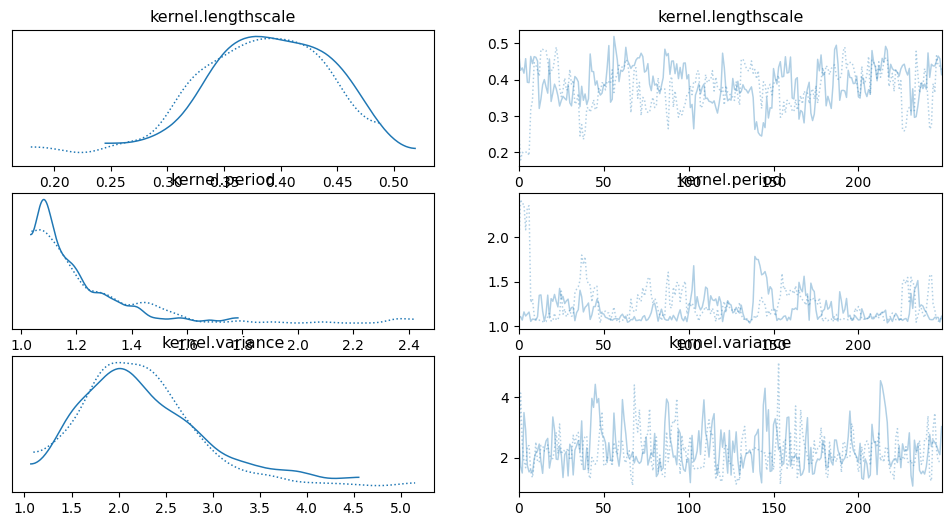

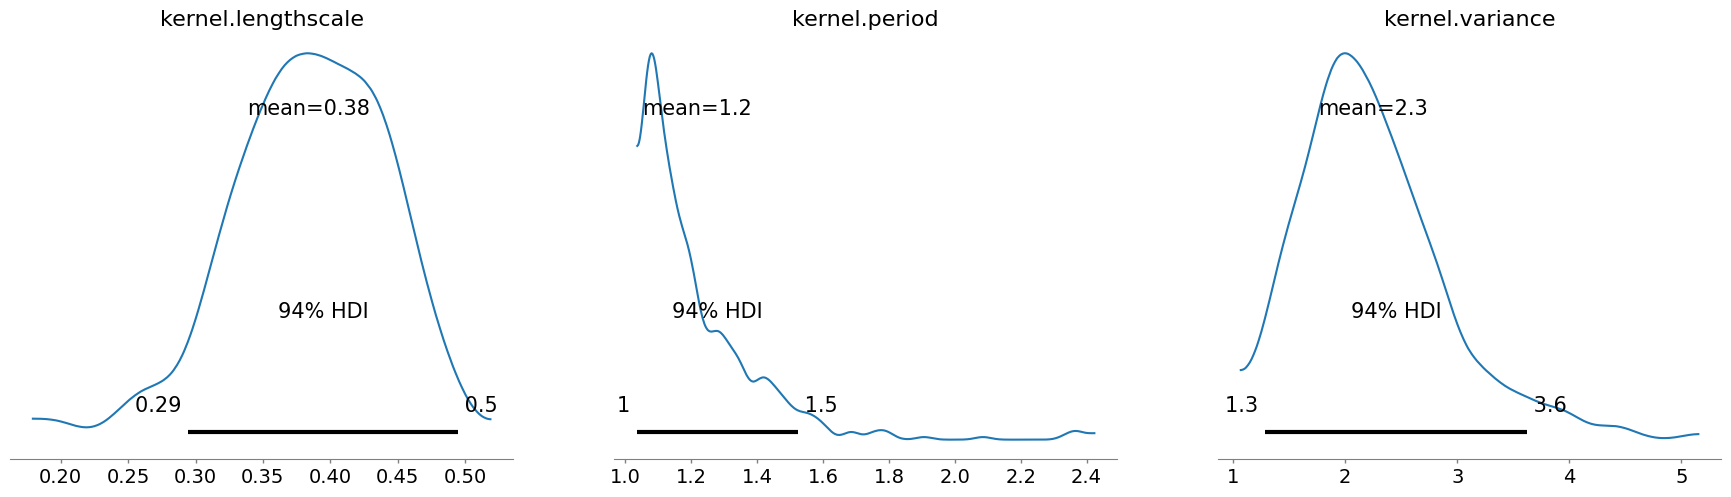

Log Likelihood:  tensor(2.0431)


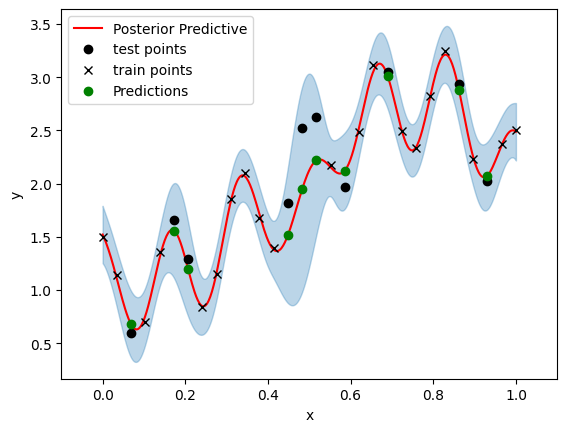

Warmup [1]:   0%|          | 0/750 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/750 [00:00, ?it/s]


                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel.lengthscale      0.42      0.07      0.42      0.31      0.54      2.76      1.26
       kernel.period      0.70      0.55      0.17      0.17      1.37      1.04      4.59
     kernel.variance      2.48      0.84      2.31      1.38      3.59    104.47      1.02

Number of divergences: 0
None


c:\Users\Mads\Documents\PML\venv\Lib\site-packages\arviz\data\io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


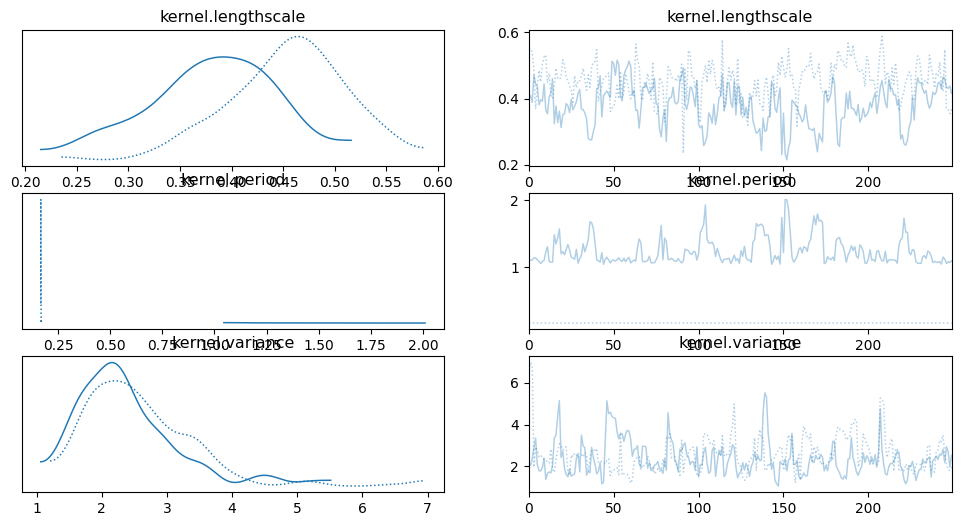

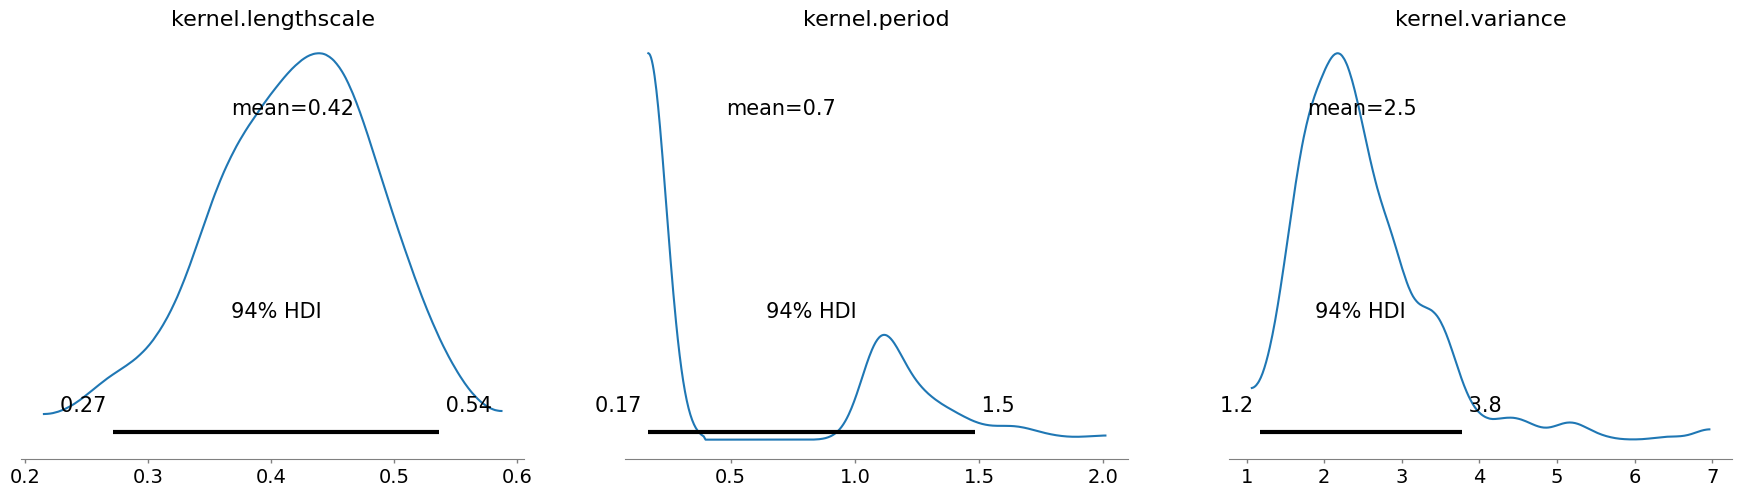

Log Likelihood:  tensor(2.0387)


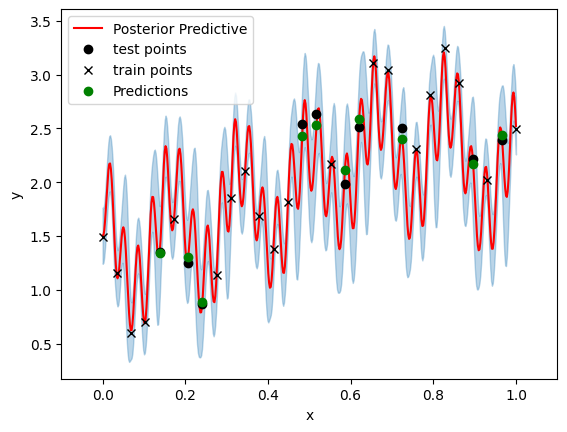

Warmup [1]:   0%|          | 0/750 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/750 [00:00, ?it/s]


                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel.lengthscale      0.30      0.15      0.22      0.13      0.51      1.09      3.30
       kernel.period      0.20      0.06      0.14      0.14      0.26      1.00    106.95
     kernel.variance      2.71      0.91      2.54      1.20      3.86      3.89      1.19

Number of divergences: 1
None


c:\Users\Mads\Documents\PML\venv\Lib\site-packages\arviz\data\io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


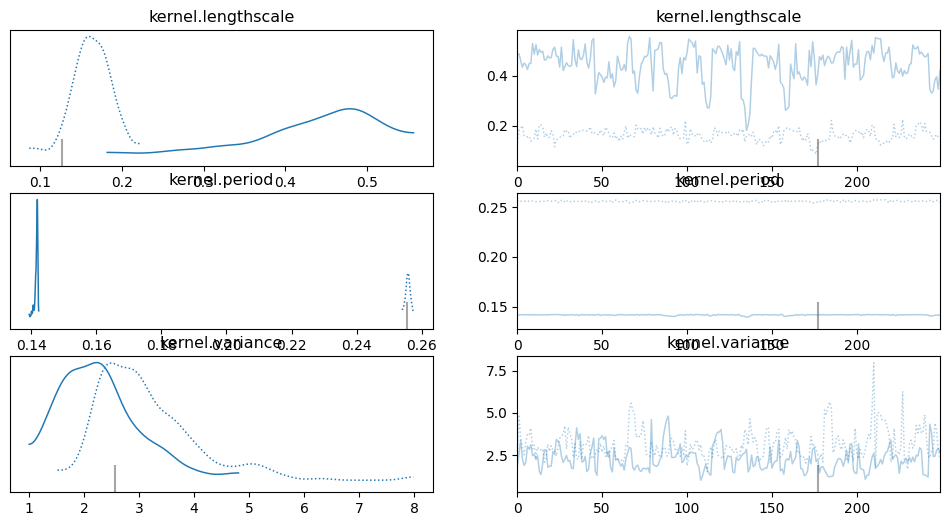

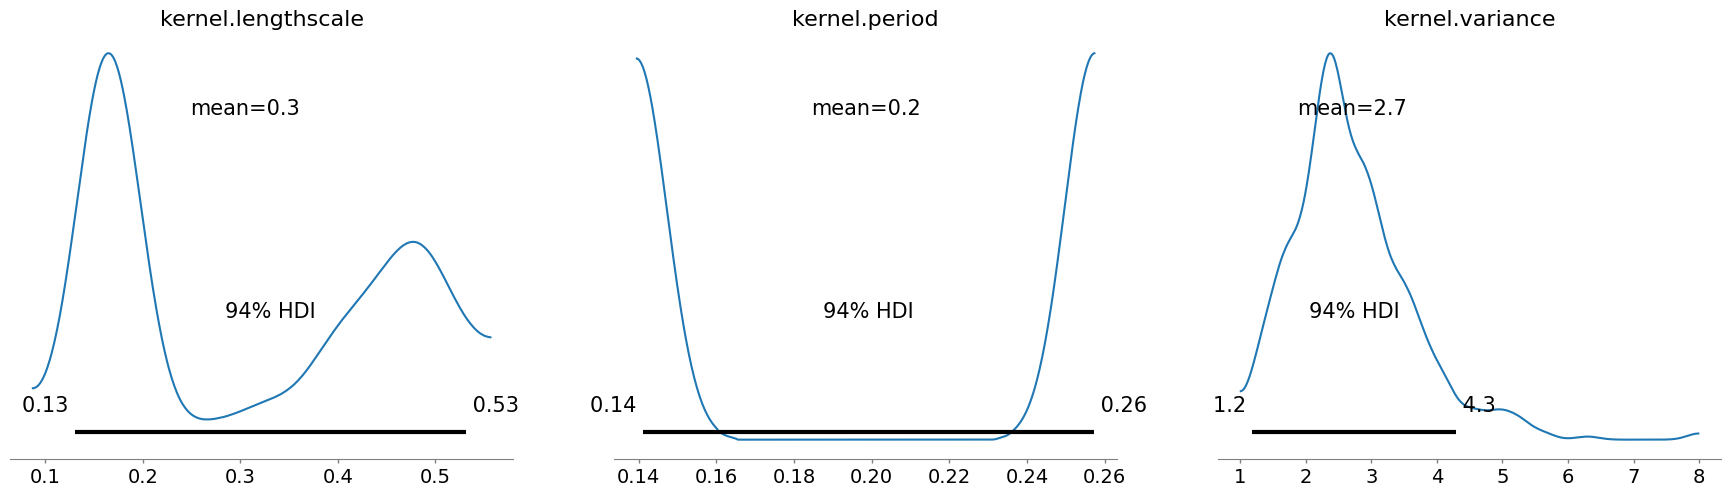

Log Likelihood:  tensor(-0.9402)


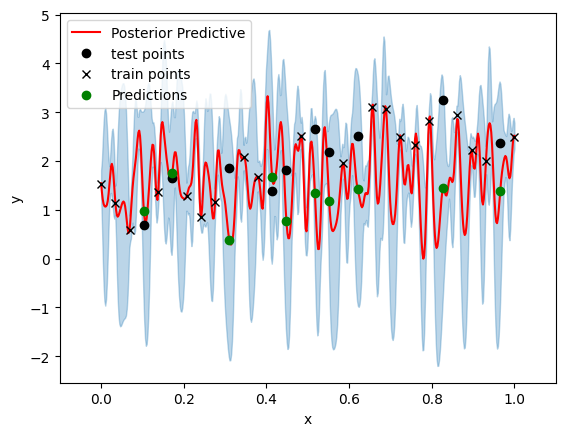

Warmup [1]:   0%|          | 0/750 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/750 [00:00, ?it/s]


                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel.lengthscale      0.29      0.13      0.21      0.12      0.46      1.08      3.73
       kernel.period      0.85      0.31      0.58      0.56      1.23      1.13      3.12
     kernel.variance      2.94      1.09      2.69      1.34      4.55      2.13      1.34

Number of divergences: 13
None


c:\Users\Mads\Documents\PML\venv\Lib\site-packages\arviz\data\io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


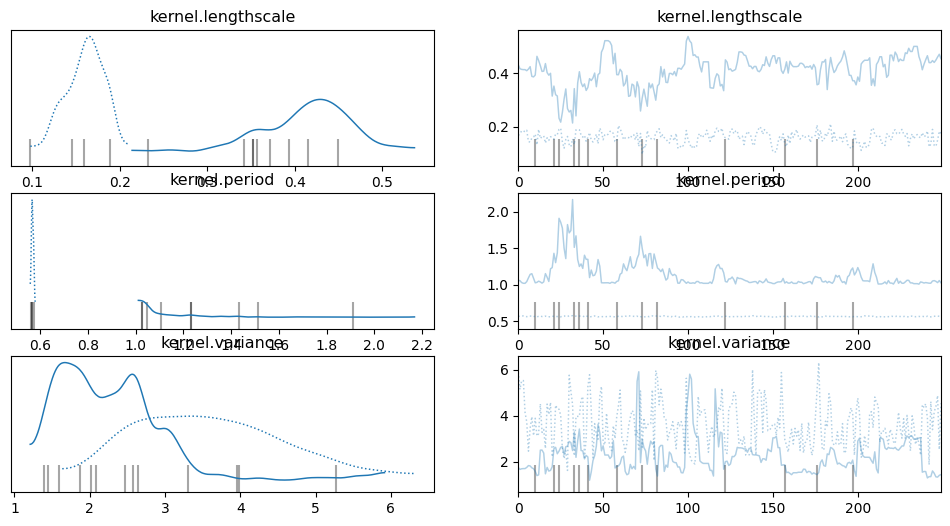

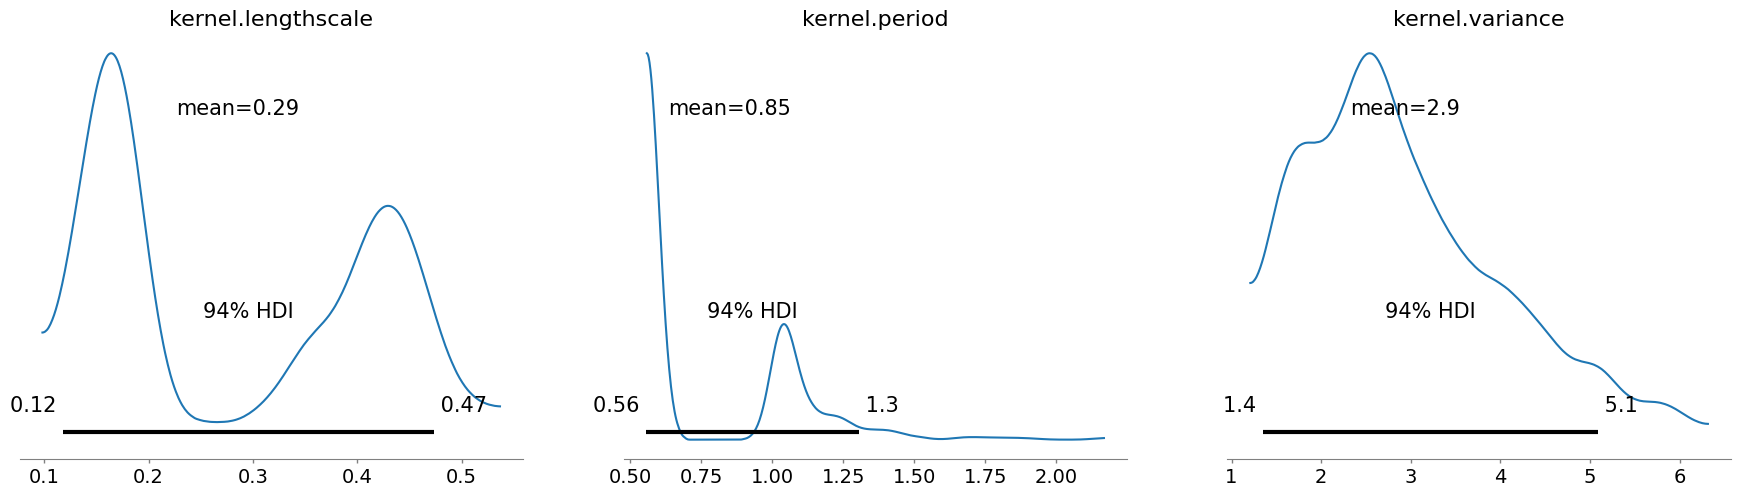

Log Likelihood:  tensor(-1.1778)


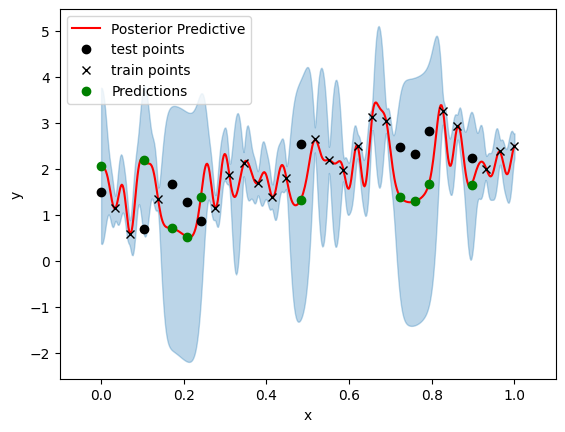

Warmup [1]:   0%|          | 0/750 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/750 [00:00, ?it/s]


                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel.lengthscale      0.28      0.12      0.23      0.13      0.45      1.10      3.11
       kernel.period      0.89      0.34      0.58      0.56      1.30      1.08      3.54
     kernel.variance      2.80      0.82      2.76      1.45      3.98      7.14      1.11

Number of divergences: 0
None


c:\Users\Mads\Documents\PML\venv\Lib\site-packages\arviz\data\io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


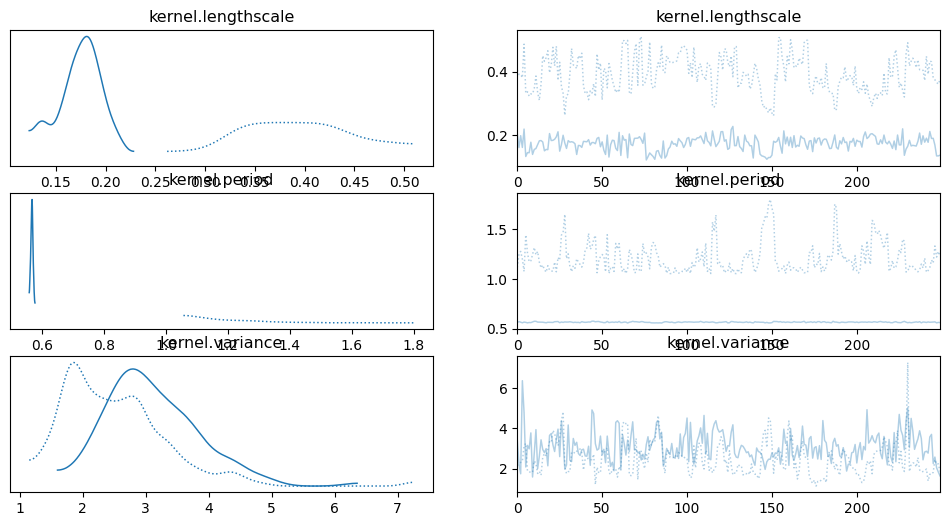

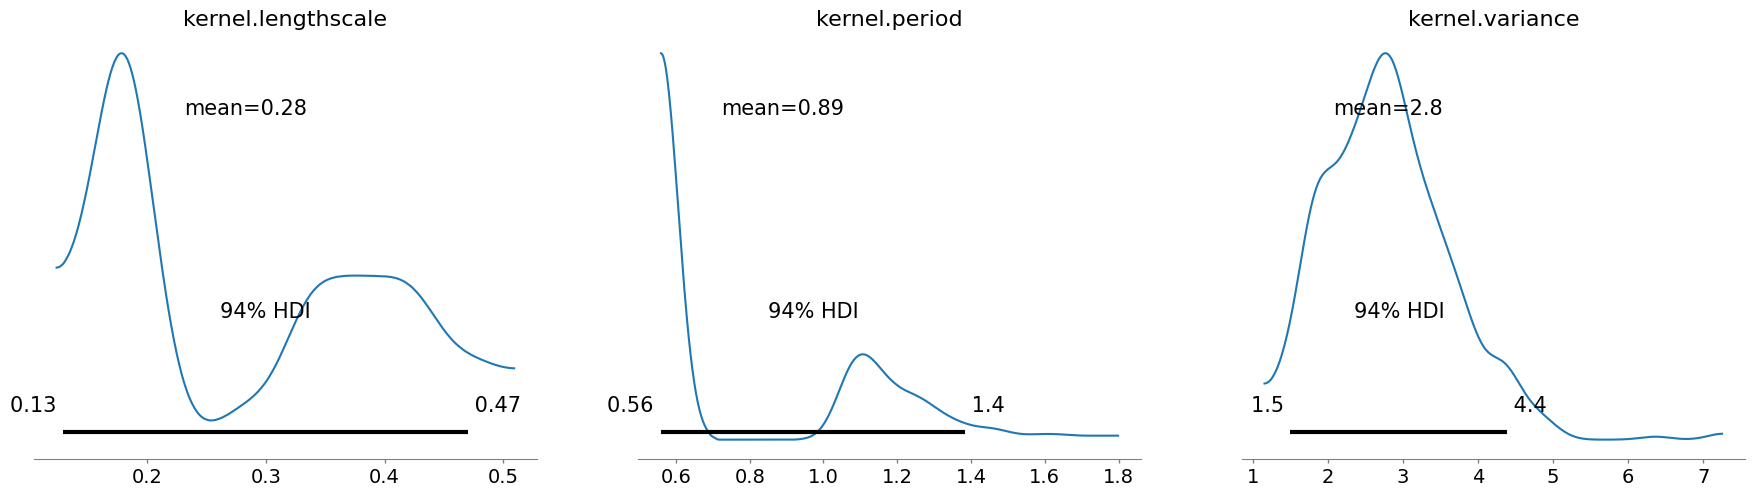

Log Likelihood:  tensor(-0.8007)


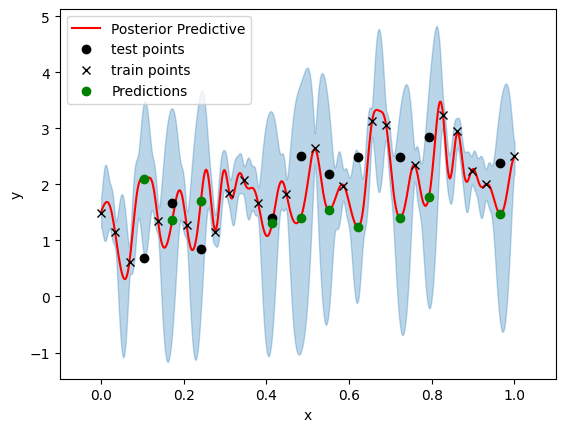

Warmup [1]:   0%|          | 0/750 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/750 [00:00, ?it/s]


                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel.lengthscale      0.27      0.12      0.21      0.12      0.44      1.13      2.81
       kernel.period      0.93      0.36      0.62      0.59      1.38      1.15      2.79
     kernel.variance      2.77      1.01      2.55      1.27      4.08      3.15      1.21

Number of divergences: 0
None


c:\Users\Mads\Documents\PML\venv\Lib\site-packages\arviz\data\io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


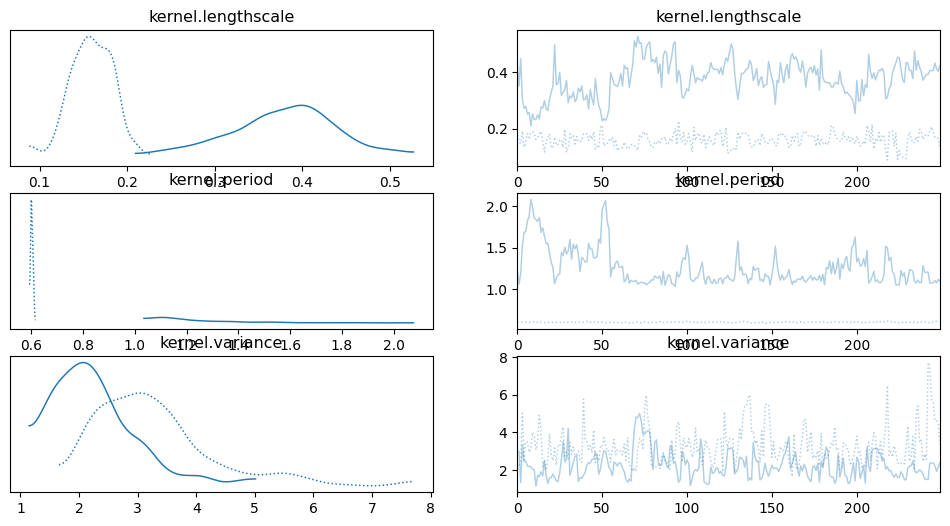

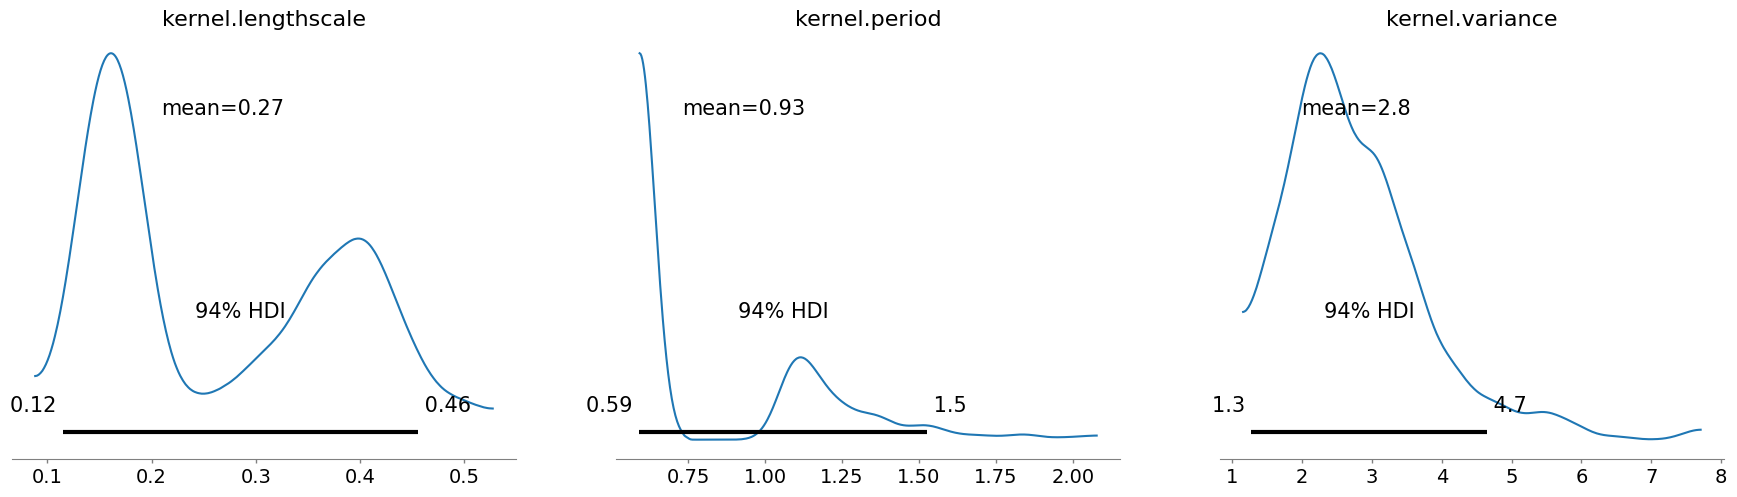

Log Likelihood:  tensor(-0.8349)


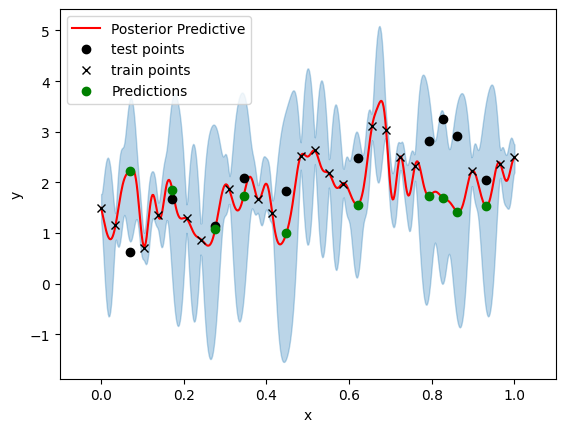

Warmup [1]:   0%|          | 0/750 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/750 [00:00, ?it/s]


                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel.lengthscale      0.32      0.10      0.27      0.19      0.45      1.12      2.89
       kernel.period      0.84      0.29      0.58      0.56      1.16      1.08      3.37
     kernel.variance      2.64      0.84      2.52      1.41      3.87     22.77      1.06

Number of divergences: 5
None


c:\Users\Mads\Documents\PML\venv\Lib\site-packages\arviz\data\io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


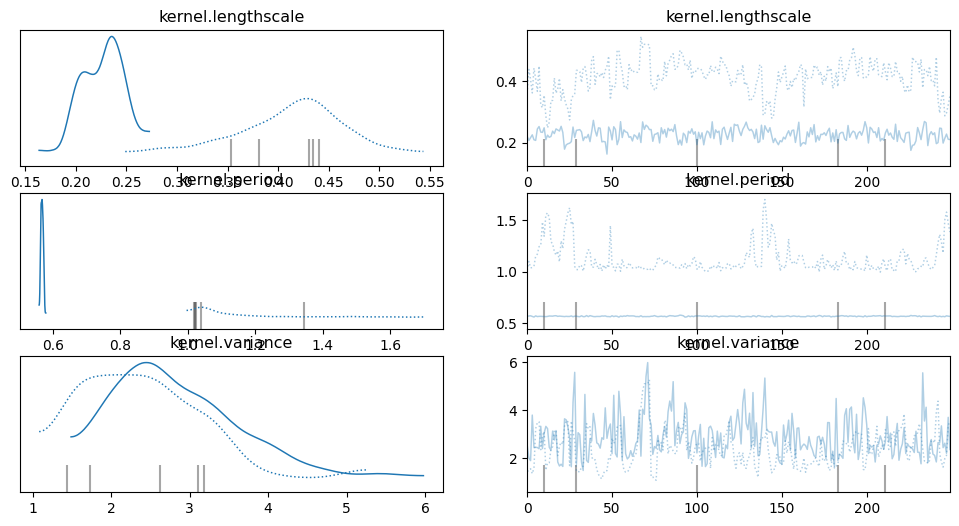

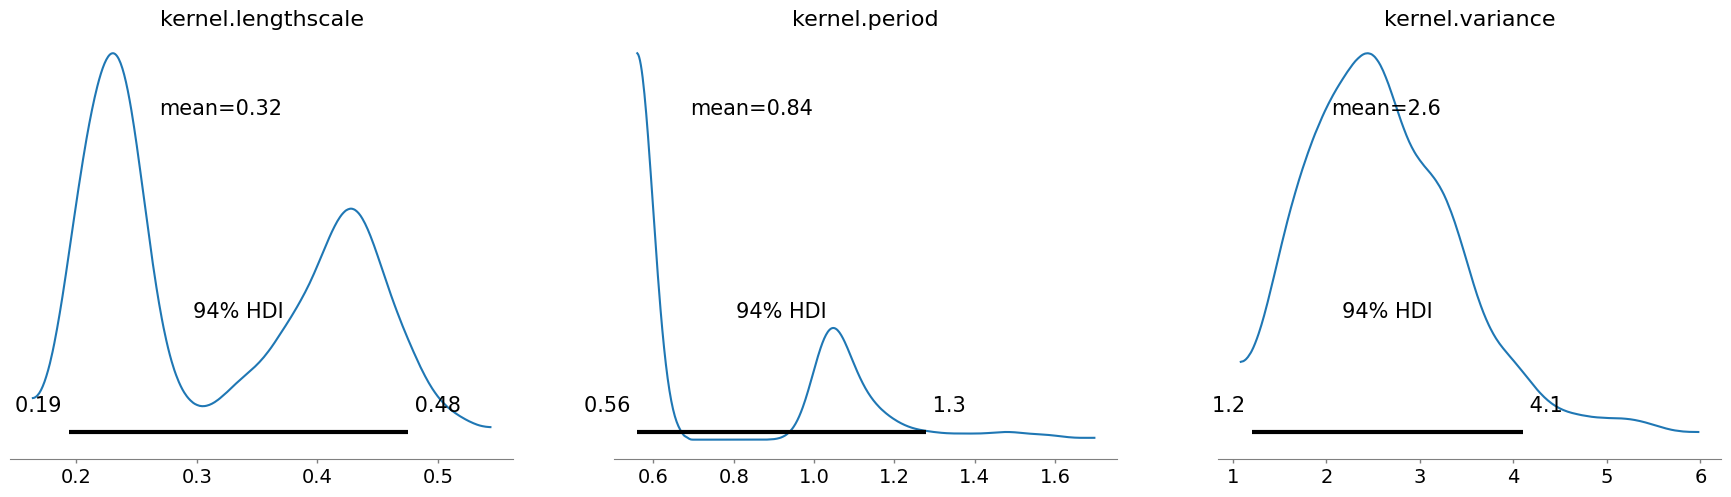

Log Likelihood:  tensor(0.1493)


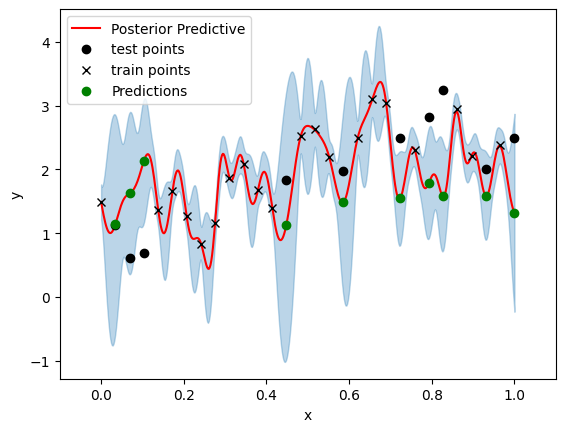

Warmup [1]:   0%|          | 0/750 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/750 [00:00, ?it/s]


                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel.lengthscale      0.40      0.06      0.41      0.31      0.49     74.86      1.01
       kernel.period      1.19      0.17      1.13      1.04      1.39     77.69      1.02
     kernel.variance      2.23      0.64      2.11      1.33      3.23    124.16      1.01

Number of divergences: 0
None


c:\Users\Mads\Documents\PML\venv\Lib\site-packages\arviz\data\io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


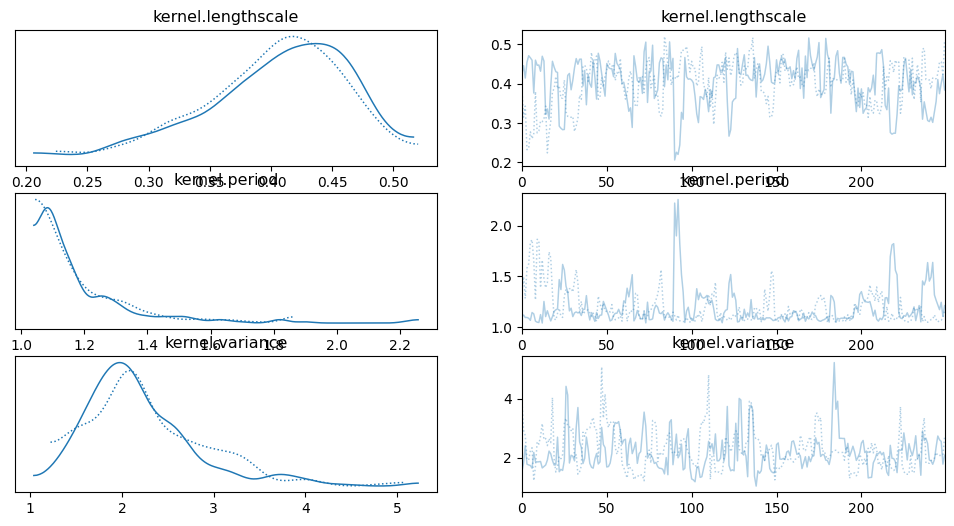

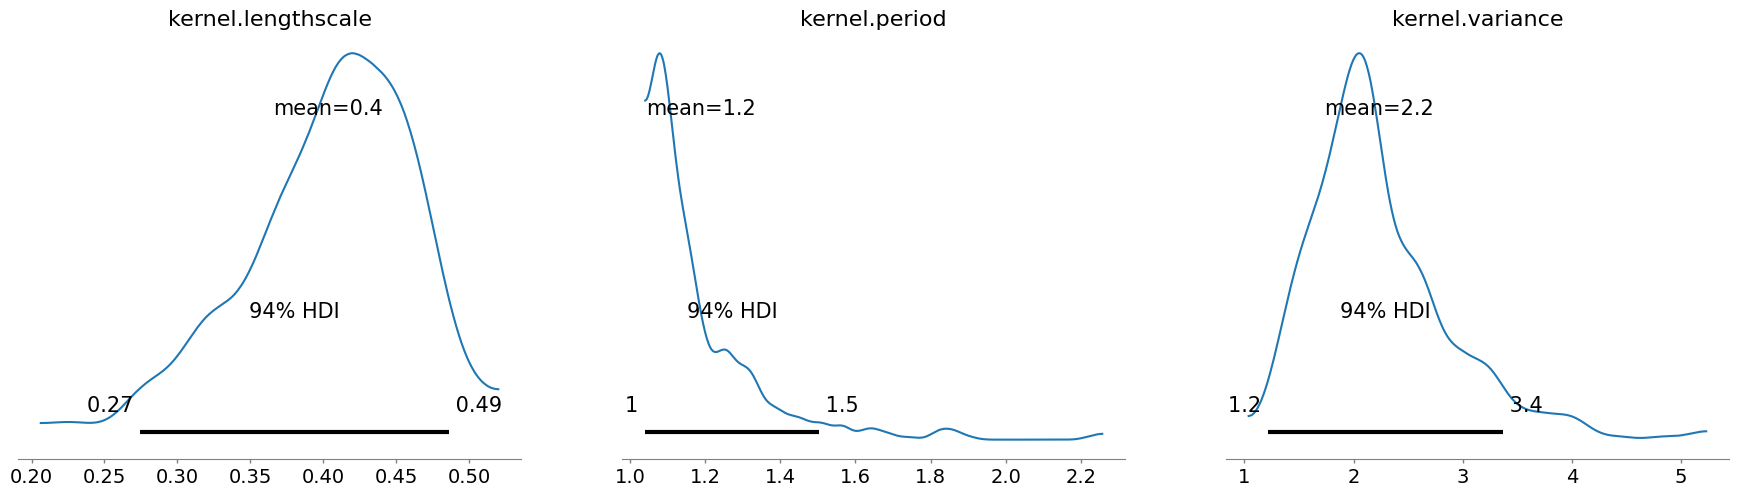

Log Likelihood:  tensor(1.7537)


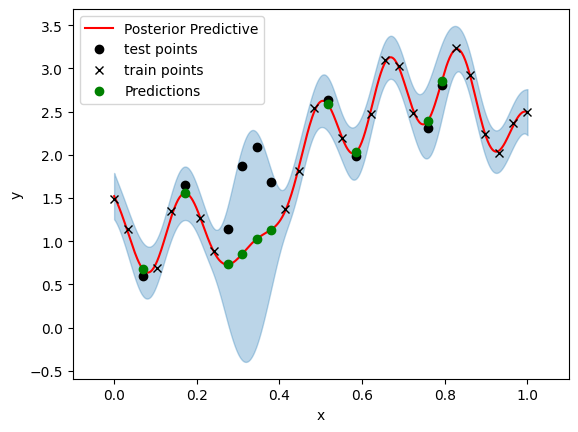

Warmup [1]:   0%|          | 0/750 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/750 [00:00, ?it/s]


                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel.lengthscale      0.42      0.06      0.42      0.32      0.50     57.16      1.02
       kernel.period      1.14      0.14      1.10      1.00      1.33     48.53      1.01
     kernel.variance      2.43      0.69      2.32      1.43      3.59    139.50      1.00

Number of divergences: 0
None


c:\Users\Mads\Documents\PML\venv\Lib\site-packages\arviz\data\io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


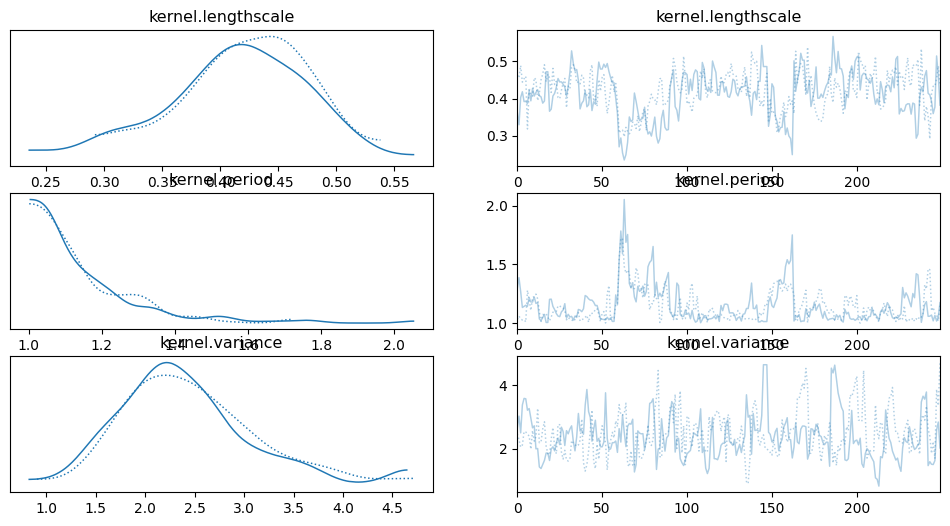

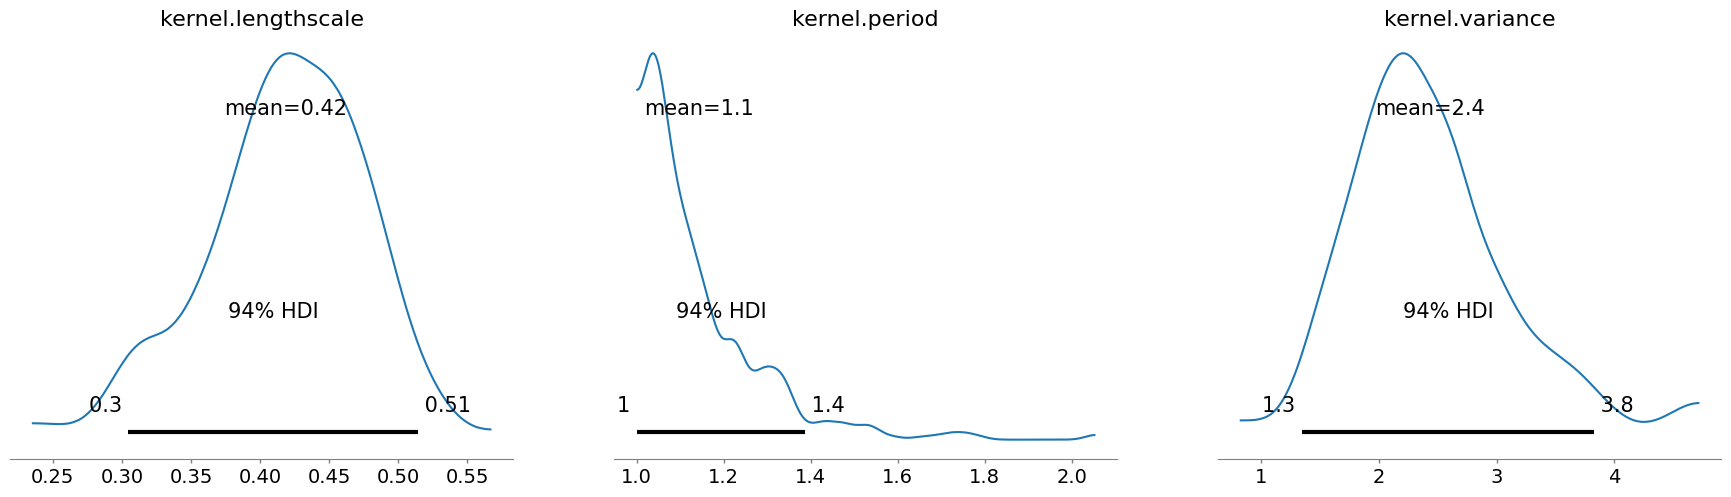

Log Likelihood:  tensor(2.1176)


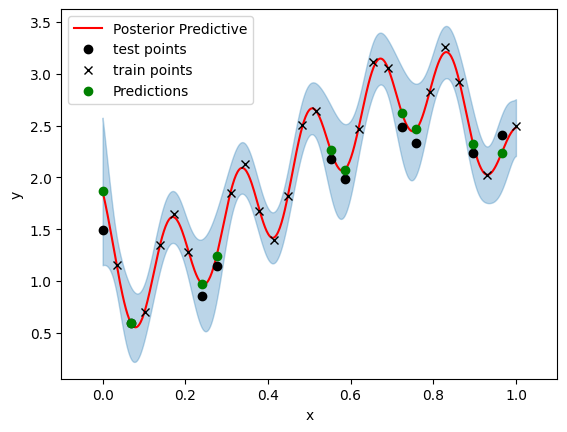

Warmup [1]:   0%|          | 0/750 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/750 [00:00, ?it/s]


                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel.lengthscale      0.43      0.06      0.43      0.34      0.52     84.04      1.00
       kernel.period      1.11      0.16      1.06      1.01      1.28     67.48      1.01
     kernel.variance      2.43      0.81      2.30      1.29      3.51     71.13      1.00

Number of divergences: 0
None


c:\Users\Mads\Documents\PML\venv\Lib\site-packages\arviz\data\io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


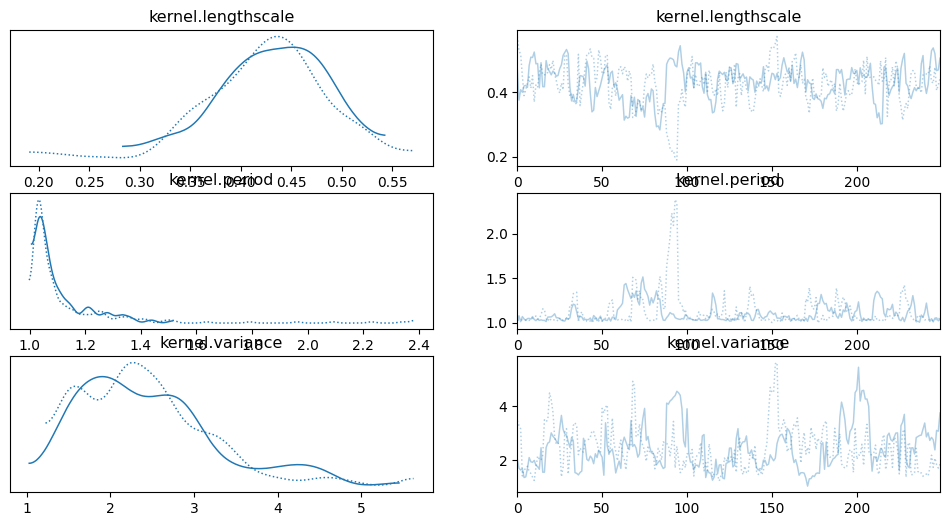

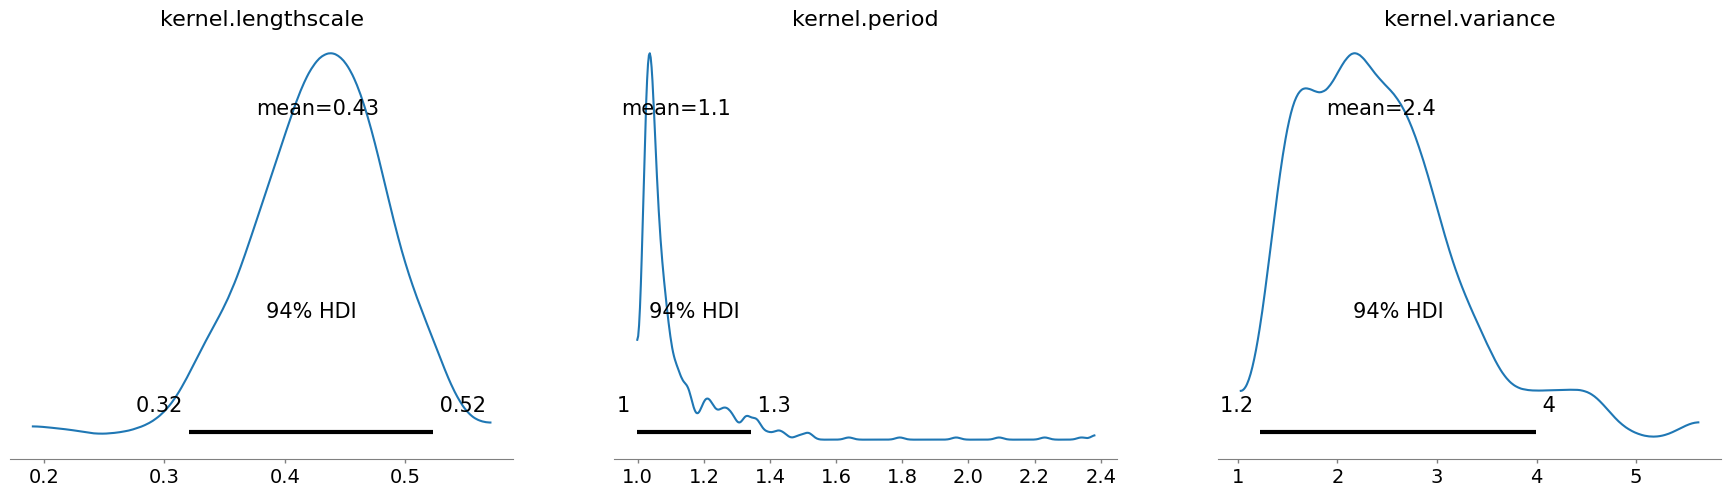

Log Likelihood:  tensor(1.7177)


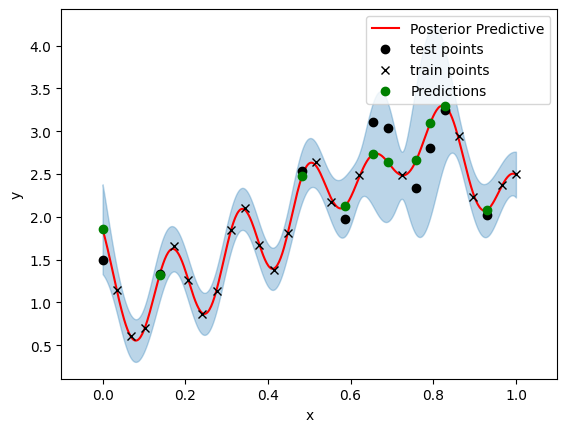

Warmup [1]:   0%|          | 0/750 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/750 [00:00, ?it/s]


                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel.lengthscale      0.40      0.05      0.40      0.31      0.48     56.86      1.02
       kernel.period      1.19      0.16      1.13      1.03      1.39     66.77      1.03
     kernel.variance      2.46      0.79      2.33      1.35      3.61    105.78      1.03

Number of divergences: 0
None


c:\Users\Mads\Documents\PML\venv\Lib\site-packages\arviz\data\io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


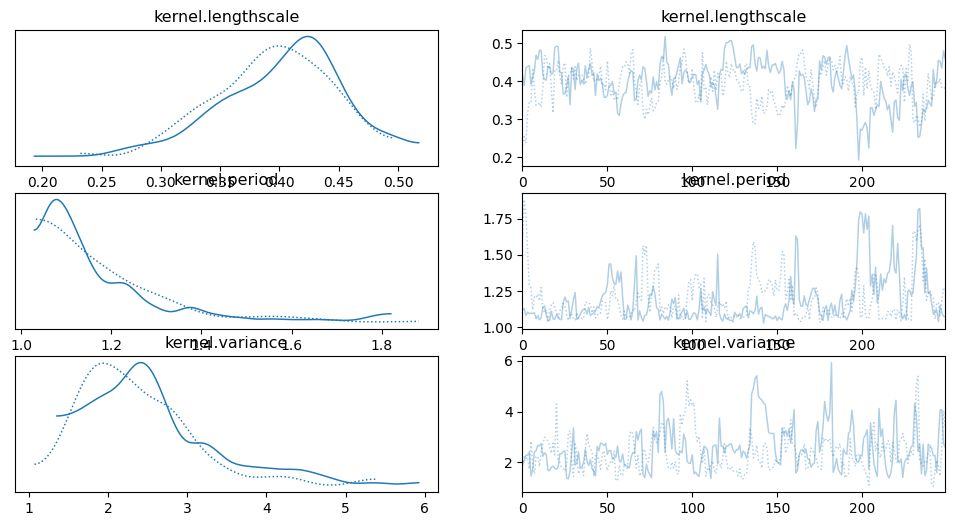

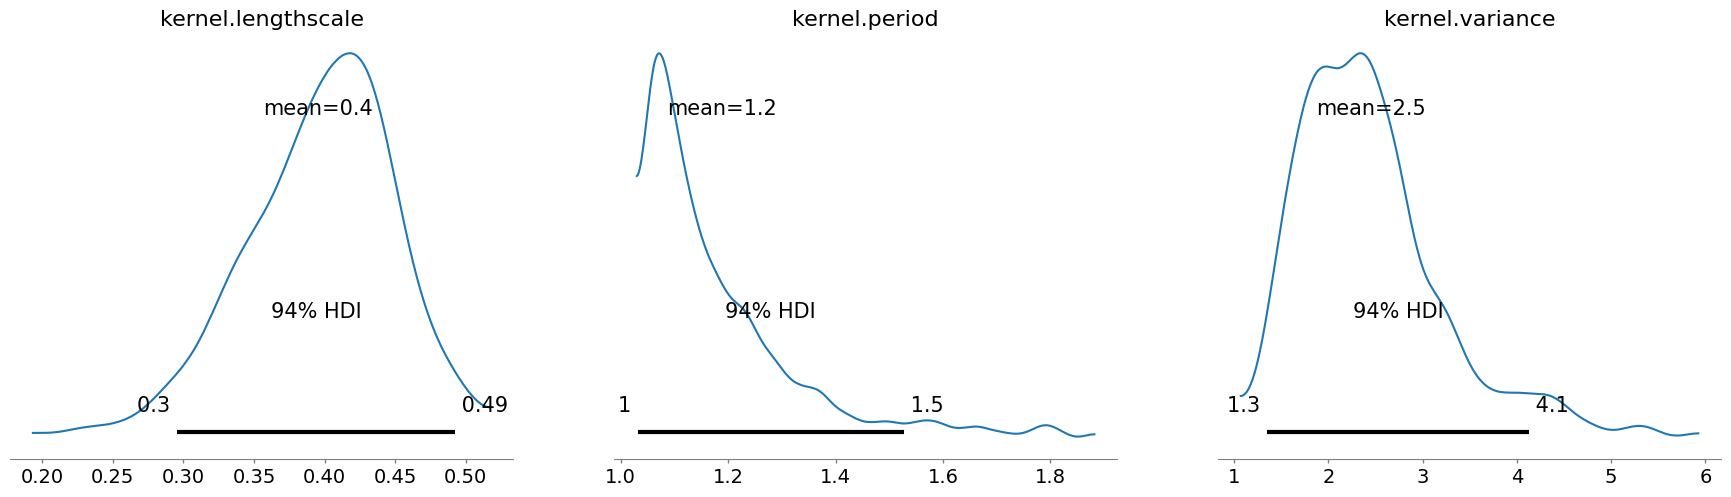

Log Likelihood:  tensor(1.5212)


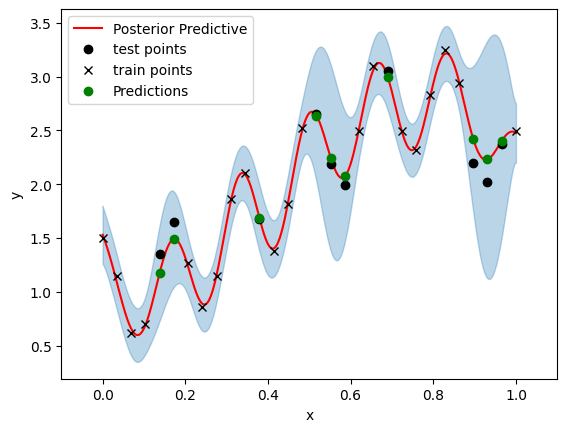

Warmup [1]:   0%|          | 0/750 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/750 [00:00, ?it/s]


                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel.lengthscale      0.42      0.05      0.42      0.35      0.51     43.73      1.04
       kernel.period      1.09      0.13      1.05      0.95      1.27     49.79      1.03
     kernel.variance      2.35      0.69      2.24      1.31      3.41    168.03      1.01

Number of divergences: 6
None


c:\Users\Mads\Documents\PML\venv\Lib\site-packages\arviz\data\io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


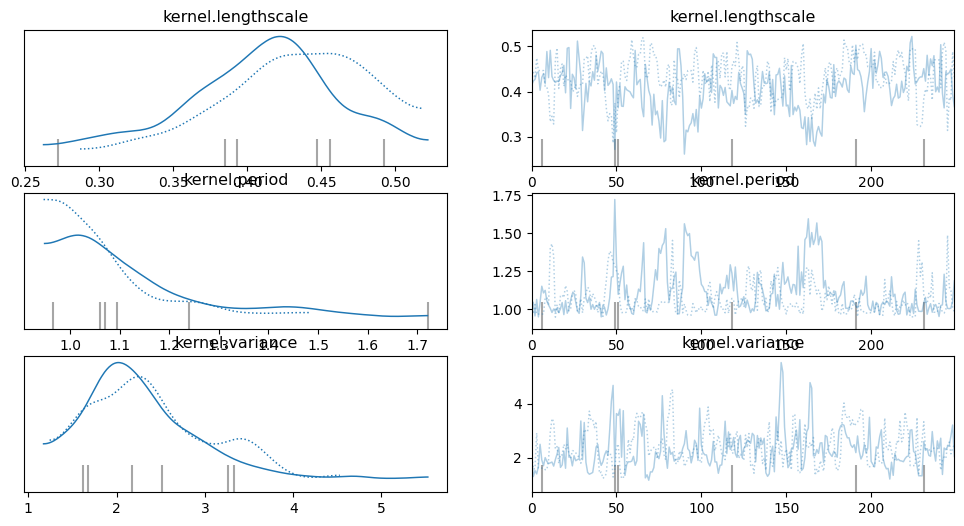

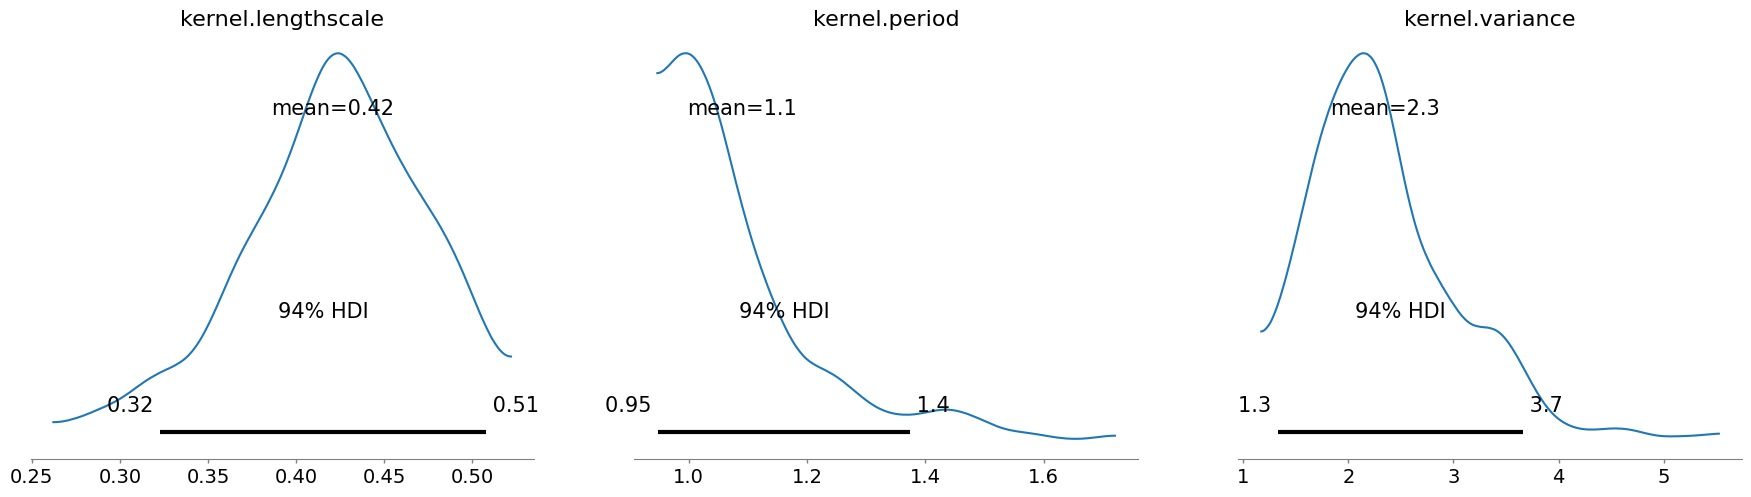

Log Likelihood:  tensor(1.5466)


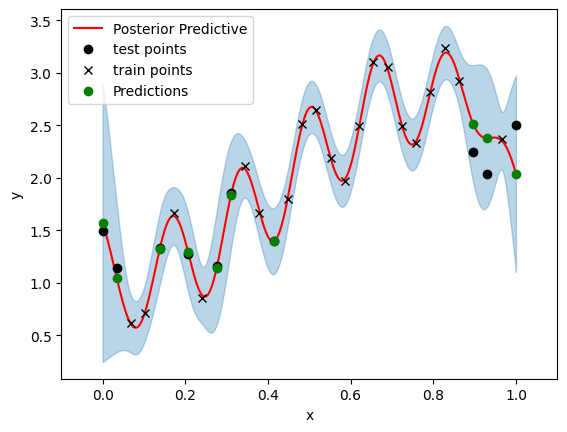

Warmup [1]:   0%|          | 0/750 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/750 [00:00, ?it/s]


                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel.lengthscale      0.29      0.11      0.24      0.15      0.46      1.17      2.56
       kernel.period      0.87      0.37      0.54      0.52      1.41      1.13      2.88
     kernel.variance      2.73      0.88      2.59      1.35      3.92     23.61      1.06

Number of divergences: 8
None


c:\Users\Mads\Documents\PML\venv\Lib\site-packages\arviz\data\io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


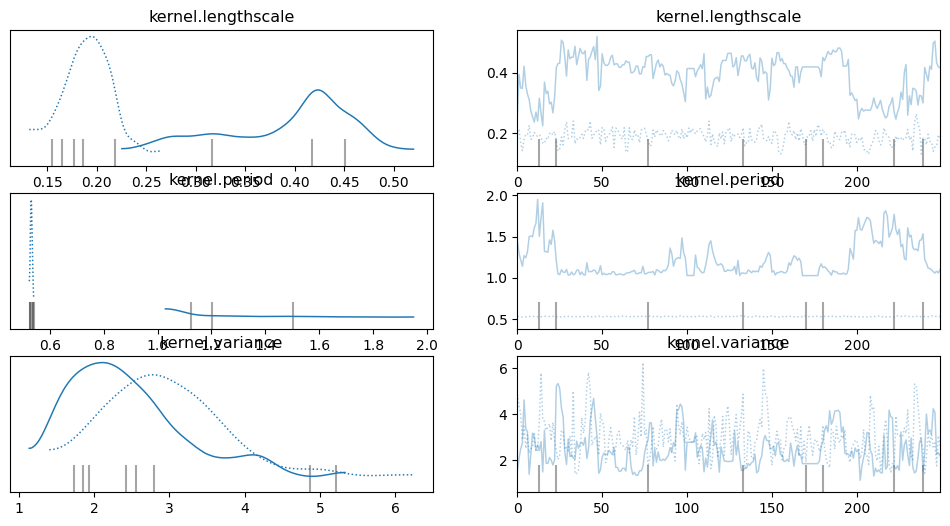

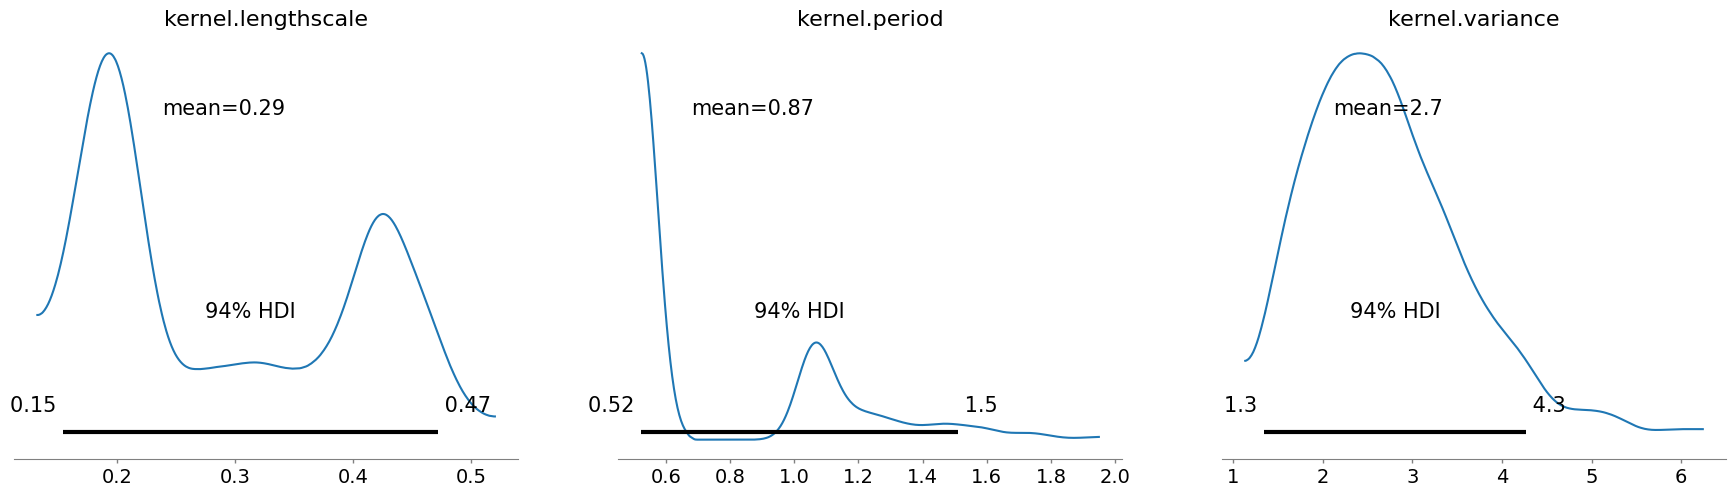

Log Likelihood:  tensor(-0.5905)


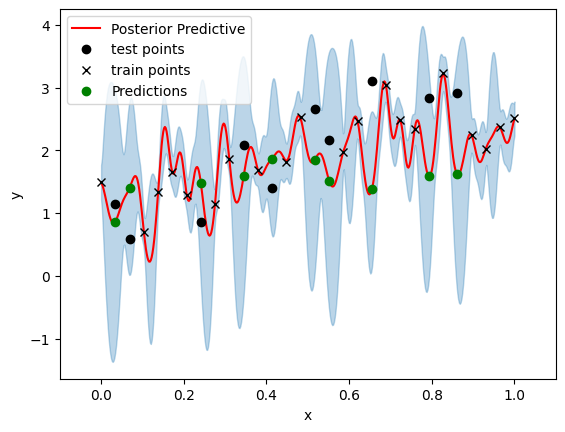

Warmup [1]:   0%|          | 0/750 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/750 [00:00, ?it/s]


                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel.lengthscale      0.25      0.07      0.22      0.16      0.35      1.20      2.23
       kernel.period      0.56      0.35      0.21      0.21      0.92      1.00    193.23
     kernel.variance      2.83      0.78      2.71      1.61      3.98    121.42      1.02

Number of divergences: 0
None


c:\Users\Mads\Documents\PML\venv\Lib\site-packages\arviz\data\io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


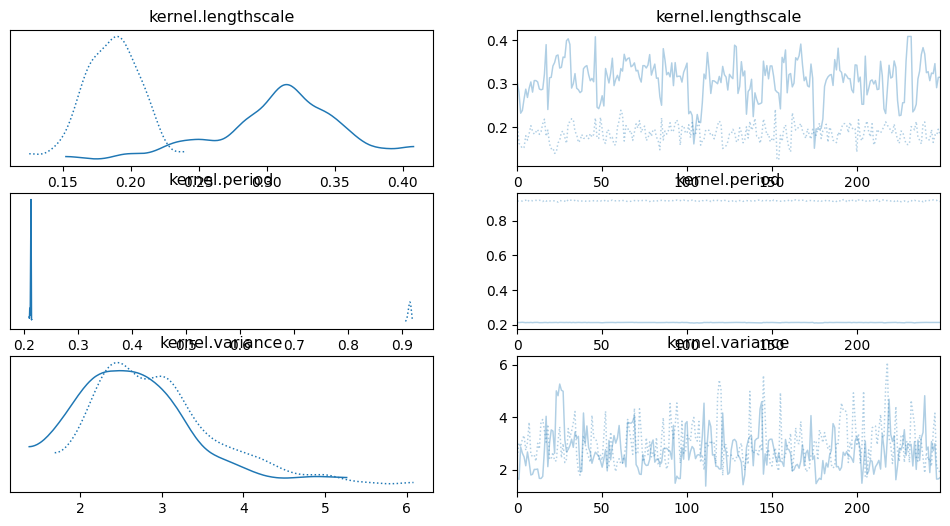

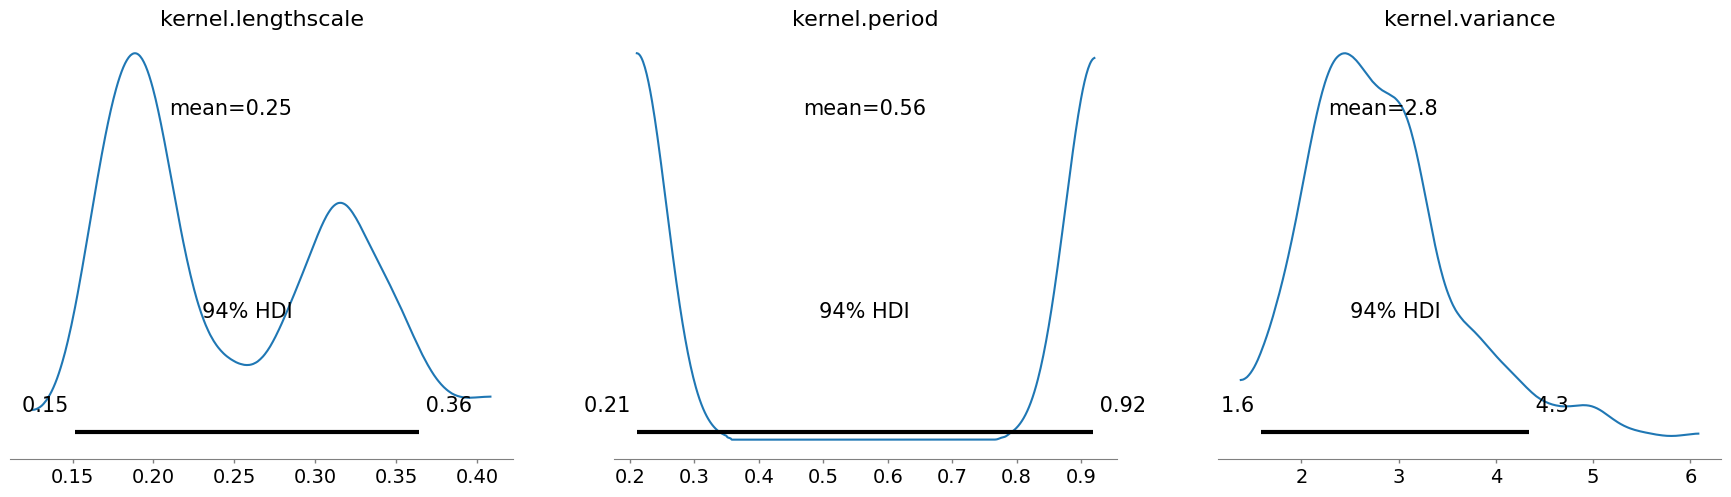

Log Likelihood:  tensor(-0.9702)


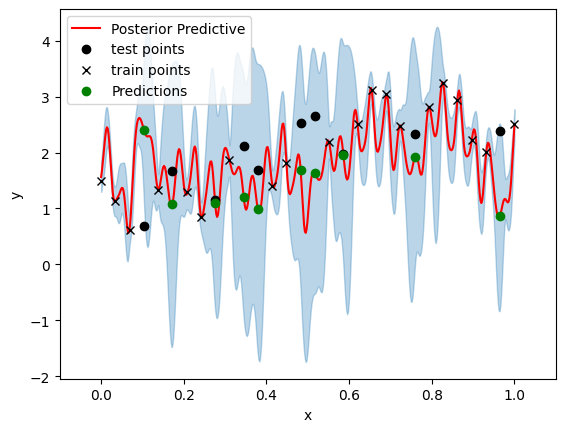

Warmup [1]:   0%|          | 0/750 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/750 [00:00, ?it/s]


                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel.lengthscale      0.30      0.08      0.28      0.19      0.43      1.19      2.40
       kernel.period      0.75      0.49      0.27      0.27      1.34      1.04      5.17
     kernel.variance      2.73      0.84      2.60      1.50      4.02      4.12      1.16

Number of divergences: 0
None


c:\Users\Mads\Documents\PML\venv\Lib\site-packages\arviz\data\io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


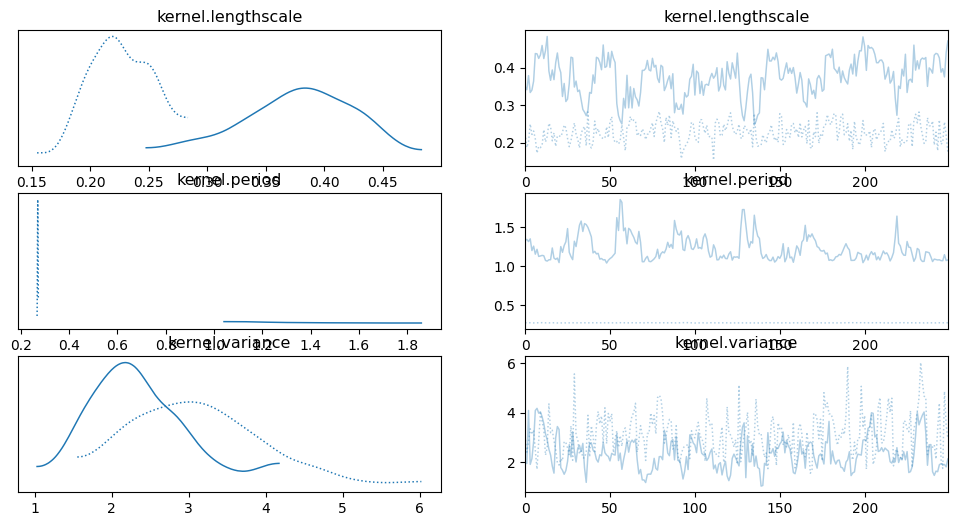

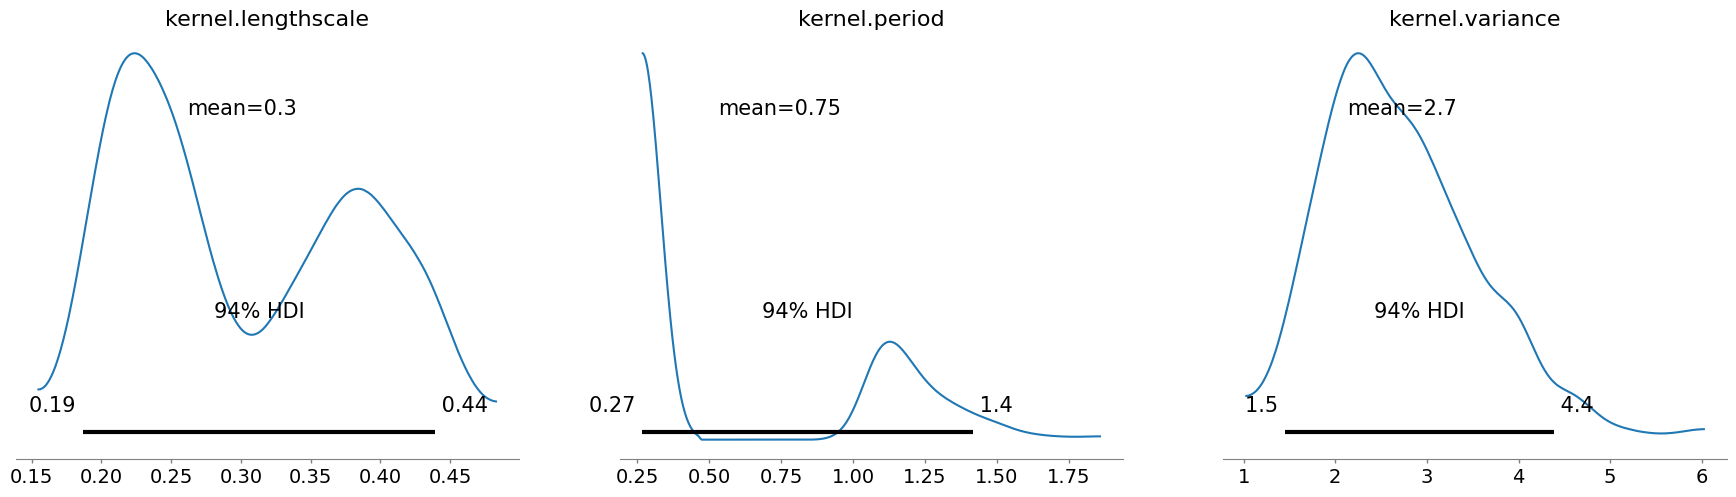

Log Likelihood:  tensor(0.6094)


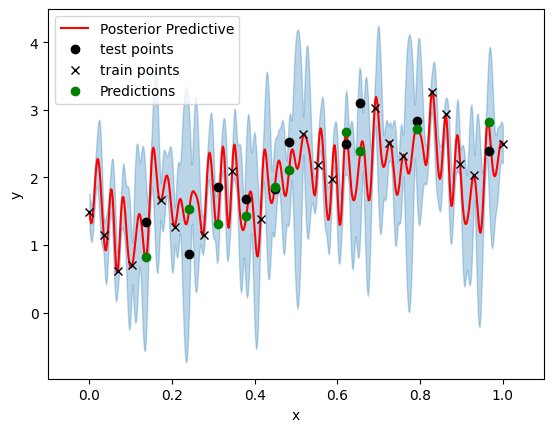

Warmup [1]:   0%|          | 0/750 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/750 [00:00, ?it/s]


                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel.lengthscale      0.36      0.06      0.36      0.27      0.47      2.98      1.27
       kernel.period      0.75      0.48      0.28      0.28      1.32      1.05      4.37
     kernel.variance      2.64      0.75      2.58      1.42      3.74     72.31      1.02

Number of divergences: 2
None


c:\Users\Mads\Documents\PML\venv\Lib\site-packages\arviz\data\io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


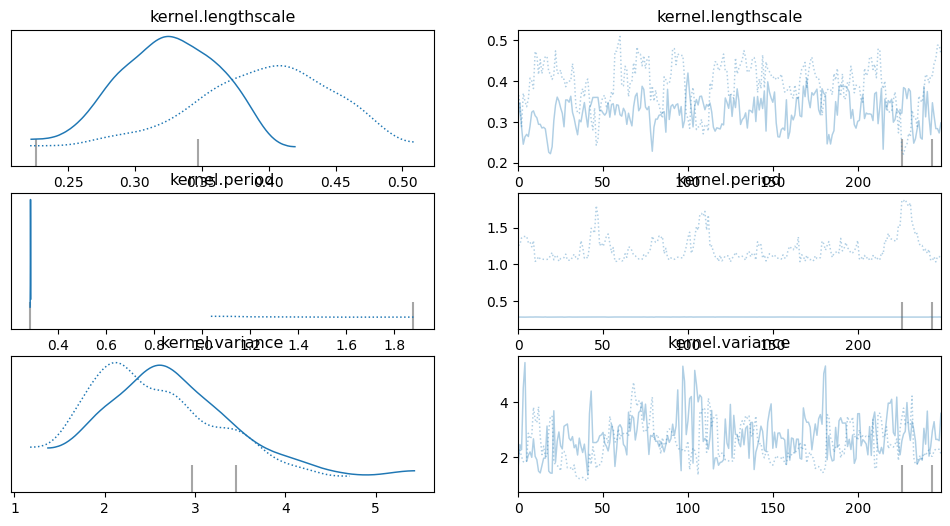

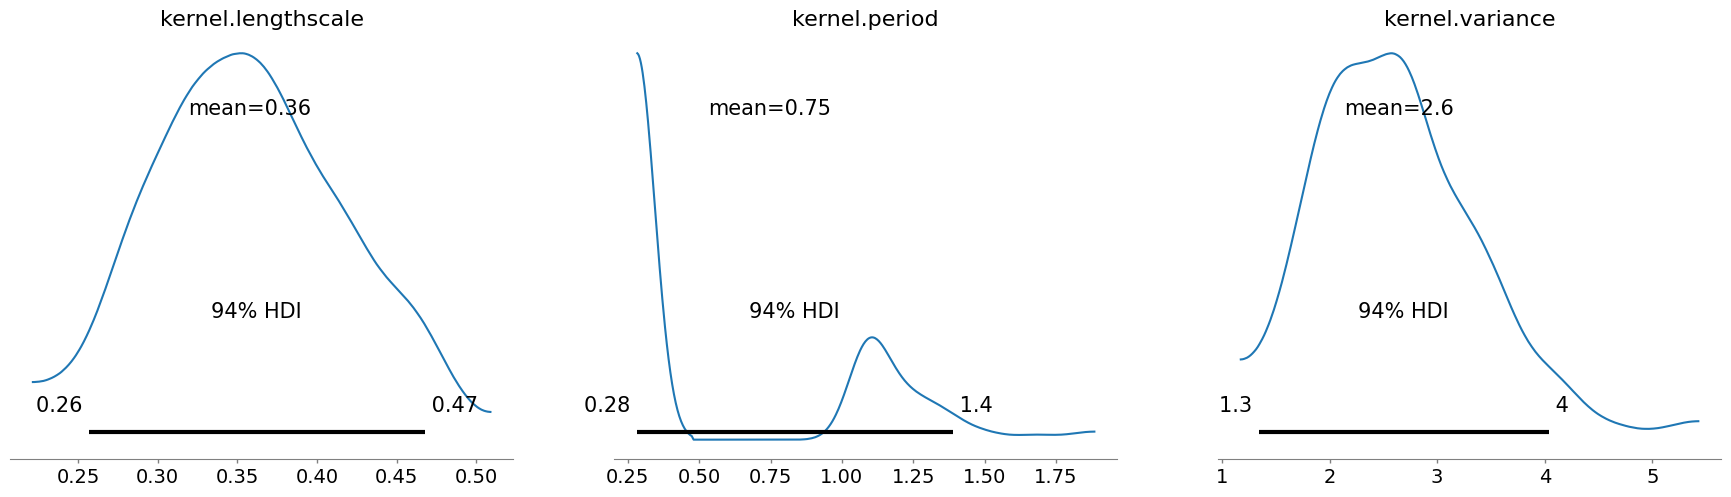

Log Likelihood:  tensor(0.6073)


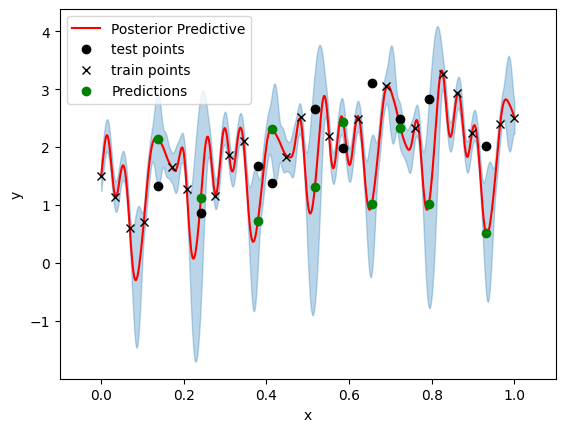

Warmup [1]:   0%|          | 0/750 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/750 [00:00, ?it/s]


                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel.lengthscale      0.32      0.11      0.27      0.18      0.48      1.13      2.71
       kernel.period      0.72      0.45      0.29      0.28      1.20      1.04      5.00
     kernel.variance      2.57      0.90      2.40      1.28      3.93     16.43      1.07

Number of divergences: 0
None


c:\Users\Mads\Documents\PML\venv\Lib\site-packages\arviz\data\io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


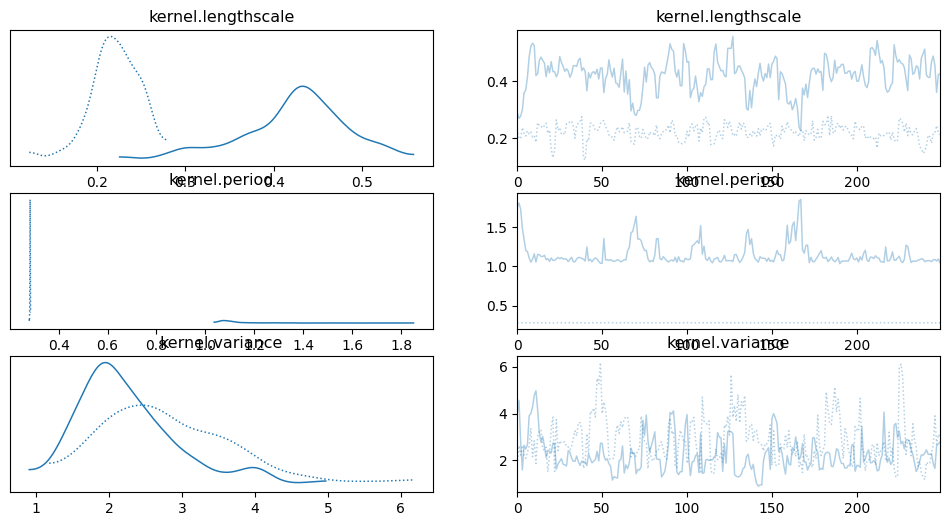

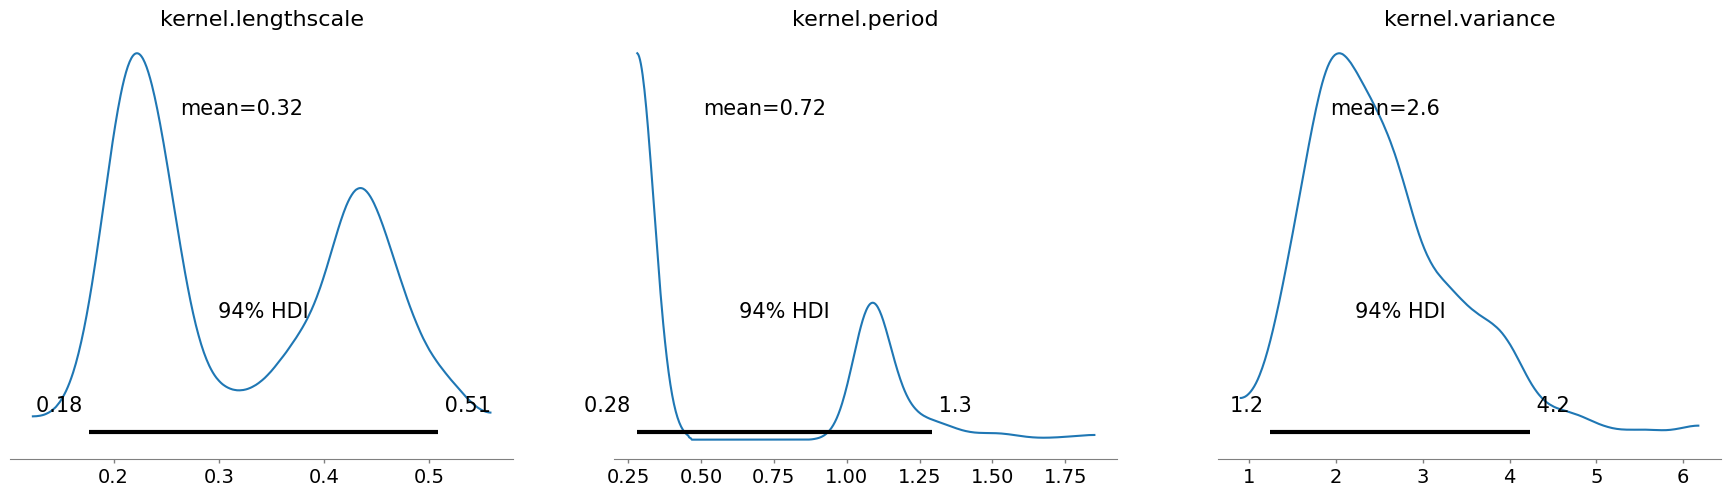

Log Likelihood:  tensor(-0.3916)


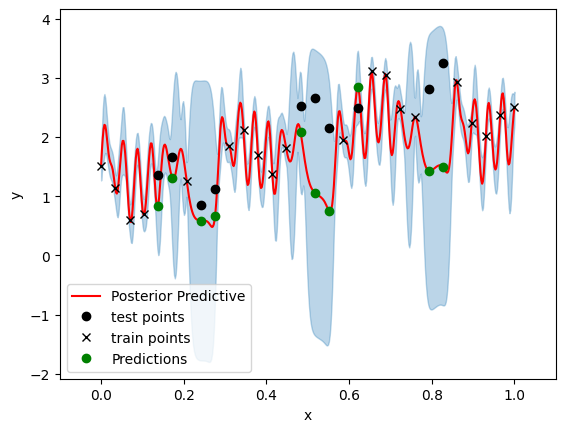

In [40]:
testlikelihoods_NUTS = []

# sample using NUTS
n_samples = 250
n_chains = 2
n_warmup = 500

# prior mean and var
mu = 0.
var = 0.5

# create joint prior distribution
mean = torch.tensor([mu, mu, mu])
covar = torch.diag(torch.tensor([var, var, var]))

prior = dist.MultivariateNormal(loc=mean, covariance_matrix=covar)

# LogNormal - obtained by transforming the multivariate normal Y ~ exp(X)
prior = dist.TransformedDistribution(
    dist.MultivariateNormal(loc=mean, covariance_matrix=covar),
    dist.transforms.ExpTransform()
)


for k in range(20):
    torch.manual_seed(k)
    pyro.set_rng_seed(k)
    pyro.clear_param_store()

    # define model
    kernel = gp.kernels.Periodic(
        input_dim=1
    )
    gpr = gp.models.GPRegression(xtrains[k], ytrains[k], kernel, noise=torch.tensor(0.01))

    # set priors on the kernel
    gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(mu, var))
    gpr.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(mu, var))
    gpr.kernel.period = pyro.nn.PyroSample(dist.LogNormal(mu, var))

    # perform NUTS to sample from posterior

    # compute second moment quantity
    nuts_kernel = pyro.infer.NUTS(gpr.model, jit_compile=True)
    mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=n_samples, warmup_steps=n_warmup,
                        num_chains=n_chains)
    mcmc.run()
    samples = mcmc.get_samples()
    print(mcmc.summary())
    
    sample_data = az.from_pyro(mcmc)
    sample_summary = az.summary(sample_data)
    az.plot_trace(sample_data)
    plt.show()
    az.plot_posterior(sample_data)
    plt.show()
    
    
    means = []
    means_all = []
    linspace = torch.linspace(0, 1, 500)
    s = 0
    s_all = 0
    for i in range(500):
        gpr.kernel.lengthscale = samples['kernel.lengthscale'][i]
        gpr.kernel.variance = samples['kernel.variance'][i]
        gpr.kernel.period = samples['kernel.period'][i]

        m_all, variances_all = gpr(linspace, full_cov=True, noiseless=False)
        m, variances = gpr(xtests[k], full_cov=True, noiseless=False)
        means.append(m.detach().cpu().numpy())
        s += variances
        means_all.append(m_all.detach().cpu().numpy())
        s_all += variances_all

    ms = torch.mean(torch.tensor(means), axis=0)
    s = s / 500
    ms_all = torch.mean(torch.tensor(means_all), axis=0)
    s_all = s_all / 500


    temp = []
    for j in range(len(ms)):
        test_likelihood = torch.distributions.normal.Normal(ms[j], s[j, j]).log_prob(ms[j])
        temp.append(test_likelihood)
    temp = torch.tensor(temp)
    mean_temp = torch.mean(temp)
    print("Log Likelihood: ", mean_temp)
    testlikelihoods_NUTS.append(mean_temp)

    # generate plot
    plt.plot(linspace, ms_all, c='red', label='Posterior Predictive')
    plt.plot(xtests[k].numpy(), ytests[k], "ko", label="test points")
    plt.plot(xtrains[k].numpy(), ytrains[k], "kx", label="train points")
    plt.plot(xtests[k].numpy(), ms, "go", zorder=10, label="Predictions")
    sd = s_all.diag().sqrt()  # standard deviation at each input point x
    plt.fill_between(
        linspace.numpy(),  # plot the two-sigma uncertainty about the mean
        (ms_all - 1.95 * sd.detach().cpu().numpy()).numpy(),
        (ms_all + 1.95 * sd.detach().cpu().numpy()).numpy(),
        color="C0",
        alpha=0.3,
    )
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    _ = plt.xlim(-0.1, 1.1)
    plt.show()

In [41]:
avg_likelihood_NUTS = torch.mean(torch.tensor(testlikelihoods_NUTS)).item()
avg_likelihood_MAP = torch.mean(torch.tensor(testlikelihoods)).item()

std_likelihood_NUTS = torch.std(torch.tensor(testlikelihoods_NUTS)).item()
std_likelihood_MAP = torch.std(torch.tensor(testlikelihoods)).item()

print('Average likelihood over the 20 experiments using MAP: ', avg_likelihood_MAP)
print('Average likelihood over the 20 experiments using NUTS: ', avg_likelihood_NUTS)

print('std likelihood over the 20 experiments using MAP: ', std_likelihood_MAP)
print('std likelihood over the 20 experiments using NUTS: ', std_likelihood_NUTS)

Average likelihood over the 20 experiments using MAP:  1.9676182270050049
Average likelihood over the 20 experiments using NUTS:  0.689578652381897
std likelihood over the 20 experiments using MAP:  1.2696900367736816
std likelihood over the 20 experiments using NUTS:  1.2534414529800415
